In [1]:
!pip install tqdm

In [2]:
import pandas as pd
import tqdm
from googletrans import Translator


In [3]:
#upload the document
df = pd.read_excel('/Users/diogoparreira/Downloads/Project Corpora/train_reviews.xlsx')
df.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [4]:
#group by index and count the number of reviews
df.groupby('index').count()

,comments
index,
1,50
5,41
8,168
9,33
10,13
...,...
6244,100
6245,130
6246,25


array([[<Axes: title={'center': 'comments'}>]], dtype=object)

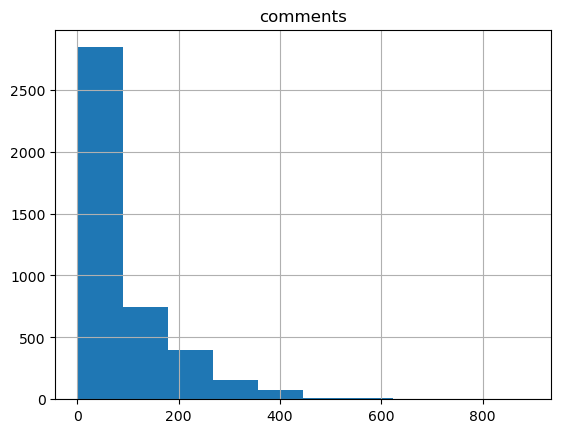

In [5]:
df.groupby('index').count().hist()



In [6]:
df['index'].max()


6248

In [7]:
df['index'].nunique()

4245

In [8]:
#Create missing Indexes(airbnbs without reviews and fill them with an empty string in the comments column)
new_rows = []
for i in range(1, 6248):
    if i not in df['index'].unique():
        new_rows.append({'index': i, 'comments': ''})

new_rows_df = pd.DataFrame(new_rows)

df = pd.concat([df, new_rows_df], ignore_index=True)
df = df.sort_values(by='index').reset_index(drop=True)

print(df)

        index                                           comments
0           1  this is a very cozy and comfortable house to s...
1           1  Ambiente acolhedor com uma localização excelen...
2           1                    Estão de parabéns super indico.
3           1                        Great stay! Would recommend
4           1  Un lugar muy acogedor, buen lugar donde hosped...
...       ...                                                ...
363279   6248  Cosy and quiet place well placed for airport a...
363280   6248  Très bel appartement, propre et complet en ter...
363281   6248  Ana was a wonderful host and her flat was as d...
363282   6248  It is a comfortable appartement, well-equipped...
363283   6248  No wifi nor answer. <br/>The wifi can’t be con...

[363284 rows x 2 columns]


In [9]:
df['index'].nunique()


6248

In [10]:
#Creating a new df that only takes  10 comments of each index
df_10 = df.groupby('index').head(10).reset_index(drop=True)
print(df_10)

       index                                           comments
0          1  this is a very cozy and comfortable house to s...
1          1  Ambiente acolhedor com uma localização excelen...
2          1                    Estão de parabéns super indico.
3          1                        Great stay! Would recommend
4          1  Un lugar muy acogedor, buen lugar donde hosped...
...      ...                                                ...
40639   6248  This apartment is the perfect little spot to s...
40640   6248  Very nice place in good location. Great contac...
40641   6248  Court séjour d'une nuit dans l'appartement d'A...
40642   6248  Ana est disponible et attentionnée.<br/>L appa...
40643   6248  appartement proche métro et gare, propre et ca...

[40644 rows x 2 columns]


array([[<Axes: title={'center': 'comments'}>]], dtype=object)

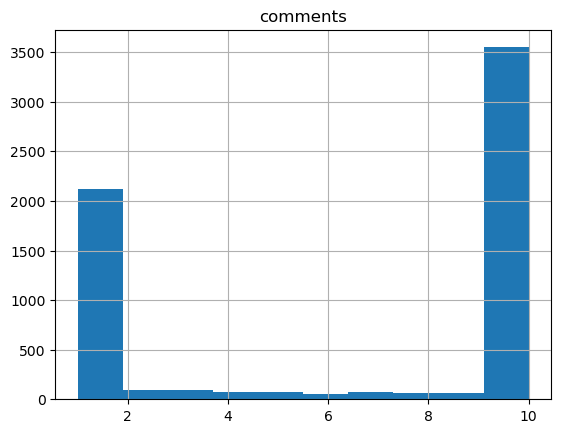

In [11]:
df_10.groupby('index').count().hist()

In [12]:
#are there any repeated comments or are they just the empty string?
df_10.groupby('index')['comments'].value_counts()[df_10.groupby('index')['comments'].value_counts() > 1]




index  comments                                                                                
4360   The host canceled this reservation 2 days before arrival. This is an automated posting.     2
5415   .                                                                                           2
5681   .                                                                                           2
5927   The host canceled this reservation the day before arrival. This is an automated posting.    2
Name: count, dtype: int64

In [13]:
#no repeated comments, so we can proceed to the next step

array([[<Axes: title={'center': 'comments'}>]], dtype=object)

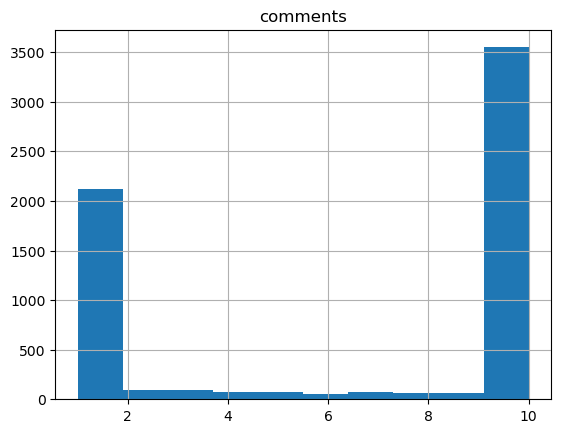

In [14]:
df_10.groupby('index').count().hist()

In [15]:
#let's check on df_10 the language of the comments
from langdetect import detect
from langdetect import DetectorFactory

DetectorFactory.seed = 0

def lang_detect(text):
    try:
        return detect(text)
    except:
        return 'error'

df_10['language'] = df_10['comments'].apply(lang_detect)



In [16]:
#summing the number of comments that are not in english 
df_10['language'].value_counts().sum() - df_10['language'].value_counts()['en']


16536

In [17]:
#check in df_10 the number of comments that are empty strings
df_10['comments'].value_counts()['']


2003

In [18]:
#show me some of those comments
df_10[df_10['comments'] == ''].head()

,index,comments,language
10,2,,error
11,3,,error
12,4,,error
23,6,,error
24,7,,error


In [19]:
#check unique values where language is error
df_10[df_10['language'] == 'error']['comments'].unique()


array(['', '.', '♥️', '..', '👏👏👏👏👏👏', '👍', '/', '5/5', '👍🏼👍🏼', '…',
       ' ...', ':-)', '👍👍👍👍👍', '👍🏻👍🏻👍🏻👍🏻', '🇵🇹', '•', '5*****', '5*',
       '👍🏼', ',', '-', '‘', '***', '10/10', '…..', '👍👍👍👍', '10/10.',
       '5⭐️', '👍🏻', '....', '❤️', '8.0', '👍🏻🤟🏻', '👍👍👍👍👍👍', '⭐️⭐️⭐️⭐️⭐️',
       '😉👌', '☹️', '🎷🦫', ': )', '👌', '5 ⭐', '5/5 👌🏿', ':)', '🙂', '👍👍'],
      dtype=object)

In [20]:
#set the language where it is error to en
df_10['language'] = df_10['language'].apply(lambda x: 'en' if x == 'error' else x)

In [22]:
from tqdm import tqdm

translator = Translator()

def translate(text):
    try:
        return translator.translate(text, dest='en').text
    except Exception as e:
        return 'error'

# Initialize a list to hold the translated comments
translated_comments = []

# Use tqdm to create a progress bar
for comment, language in tqdm(zip(df_10['comments'], df_10['language']), desc="Translating comments", total=len(df_10)):
    if language != 'en':
        translated_comments.append(translate(comment))
    else:
        translated_comments.append(comment)

# Assign the translated comments to the new column
df_10['comments_en'] = translated_comments

# Print the translated comments
print(df_10['comments_en'])

# Check for any null values in the translated comments
null_count = df_10['comments_en'].isnull().sum()
print(f"Number of null translations: {null_count}")

# Check the number of successful translations by excluding 'error'
successful_translations = df_10['comments_en'].value_counts().sum() - df_10['comments_en'].value_counts().get('error', 0)
print(f"Number of successful translations: {successful_translations}")



Translating comments: 100%|██████████| 40644/40644 [4:03:56<00:00,  2.78it/s]  


0        this is a very cozy and comfortable house to s...
1        Welcoming environment with an excellent locati...
2                          Congratulations super indicate.
3                              Great stay! Would recommend
4        A very cozy place, a good place to stay, very ...
                               ...                        
40639    This apartment is the perfect little spot to s...
40640    Very nice place in good location. Great contac...
40641    Short overnight stay in Ana's apartment arrivi...
40642    Ana is available and attentive. <br/> The apar...
40643    Apartment near metro and station, clean and qu...
Name: comments_en, Length: 40644, dtype: object
Number of null translations: 0
Number of successful translations: 40641


In [23]:
df_10.head()


,index,comments,language,comments_en
0,1,this is a very cozy and comfortable house to s...,en,this is a very cozy and comfortable house to s...
1,1,Ambiente acolhedor com uma localização excelen...,pt,Welcoming environment with an excellent locati...
2,1,Estão de parabéns super indico.,pt,Congratulations super indicate.
3,1,Great stay! Would recommend,en,Great stay! Would recommend
4,1,"Un lugar muy acogedor, buen lugar donde hosped...",es,"A very cozy place, a good place to stay, very ..."


In [24]:
#pickle df_10
df_10.to_pickle('/Users/diogoparreira/Downloads/Project Corpora/train_reviews10.pkl')



In [25]:
#check if any comments are error
df_10[df_10['comments_en'] == 'error']

,index,comments,language,comments_en
9925,1520,Une personne nous attendait quand on est arriv...,fr,error
13100,2000,"Não recomendo, de todo, o alojamento. Explico ...",pt,error
16084,2465,"Longe de atender minhas espectativas, vou come...",pt,error


In [26]:
#print the comments that are error in portuguese, without truncating the text
pd.set_option('display.max_colwidth', None)
df_10[df_10['comments_en'] == 'error']['comments'].unique()


array(["Une personne nous attendait quand on est arrivé comme convenu. Malheureusement pas de conseils et pas de rencontres avec l'hôte, donc pas de bonnes adresses à voir et à faire.",
       'Não recomendo, de todo, o alojamento. Explico de seguida por que motivos, para que dúvidas não restem e ninguém volte a passar pelo mesmo que eu passei.<br/>Logo após a reserva, no dia 24.07.2020, recebi um e-mail de “Joana (Airbnb User) <joana-8xifygxl92pqgg6h@host.airbnb.com” , que, a par da localização da propriedade e outras informações relacionadas com a mesma, referia o seguinte:<br/>\t“Seu anfitrião local é Manuela, ela irá encontrar-se consigo no apartamento e fazer o seu check-in com todas as medidas de segurança. Peço o favor de trazerem máscara colocada. Peço o favor de lerem o e-mail até ao fim que tem toda a informação que necessitam de forma a que o check in não dure mais do que 10 minutos”.<br/>\tNo próprio dia e conforme solicitado, entrei em contacto com a aludida Joana, com o i

In [27]:
# Apply the function to the 'comments' column where 'comments_en' is 'error'
cleaned_data = df_10[df_10['comments_en'] == 'error']['comments'].apply(clean_html_tags)

# Extract cleaned text and tag count
cleaned_comments = cleaned_data.apply(lambda x: x[0])
tag_counts = cleaned_data.apply(lambda x: x[1])

# Assign the cleaned text and tag count back to the DataFrame
df_10.loc[df_10['comments_en'] == 'error', 'comments'] = cleaned_comments
df_10.loc[df_10['comments_en'] == 'error', 'tag_count'] = tag_counts

# Verify the cleaning by printing the unique comments where 'comments_en' is 'error'
print(df_10[df_10['comments_en'] == 'error'][['comments', 'tag_count']].head())



NameError: name 'clean_html_tags' is not defined

In [28]:
from deep_translator import MyMemoryTranslator
# Initialize the MyMemoryTranslator
translator = MyMemoryTranslator(source='auto', target='en-US')

# Define the fallback translation function using MyMemoryTranslator
def mymemory_translate(text):
    try:
        return translator.translate(text)
    except Exception as e:
        return 'error'

# Find the rows with 'error' in the 'comments_en' column
error_indices = df_10[df_10['comments_en'] == 'error'].index

# Retranslate the comments that have 'error' using MyMemoryTranslator
for idx in tqdm(error_indices, desc="Re-translating errors"):
    original_comment = df_10.at[idx, 'comments']
    translated_comment = mymemory_translate(original_comment)
    df_10.at[idx, 'comments_en'] = translated_comment

# Print the translated comments
print(df_10['comments_en'])

# Check for any null values in the translated comments
null_count = df_10['comments_en'].isnull().sum()
print(f"Number of null translations: {null_count}")

# Check the number of successful translations by excluding 'error'
successful_translations = df_10['comments_en'].value_counts().sum() - df_10['comments_en'].value_counts().get('error', 0)
print(f"Number of successful translations: {successful_translations}")

Re-translating errors: 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  this is a very cozy and comfortable house to stay in.never worry about the safety and the host is very nice.very close to parque metro station.easy to find.
1                                                                                                                                                                                                                                                                                                                                                                       

In [29]:
#check if any comments are error
df_10[df_10['comments_en'] == 'error']

index  \
13100   2000   
16084   2465   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [30]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] ="/Users/diogoparreira/Downloads/idyllic-silo-423522-f5-d45c376d14ed.json"

from google.cloud import translate_v2 as translate
import pandas as pd
from tqdm import tqdm

# Initialize Google Translate client
client = translate.Client()

# Define a function to translate text
def translate_text(text, target_language='en'):
    translation = client.translate(text, target_language=target_language)
    return translation['translatedText']

# Filter only rows where 'comments_en' column contains 'error'
error_comments = df_10[df_10['comments_en'] == 'error']['comments']

# Translate 'error' comments to English
tqdm.pandas()  # Enable progress bar for pandas operations
df_10.loc[df_10['comments_en'] == 'error', 'comments_en'] = error_comments.progress_apply(translate_text)

# Verify the translation
print(df_10[['comments', 'comments_en']].head())


100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                                                                                                                                                                                      comments  \
0                                 this is a very cozy and comfortable house to stay in.never worry about the safety and the host is very nice.very close to parque metro station.easy to find.   
1                                                                                                                 Ambiente acolhedor com uma localização excelente. Custo-benefício muito bom!   
2                                                                                                                                                              Estão de parabéns super indico.   
3                                                                                                                                                                  Great stay! Would recommend   
4  Un lugar muy acogedor, buen

In [31]:
#check if any comments are error
df_10[df_10['comments_en'] == 'error']

,index,comments,language,comments_en


In [32]:
#pickle df_10
df_10.to_pickle('/Users/diogoparreira/Downloads/Project Corpora/train_reviews_10translated.pkl')

array([[<Axes: title={'center': 'comments'}>,
        <Axes: title={'center': 'language'}>],
       [<Axes: title={'center': 'comments_en'}>, <Axes: >]], dtype=object)

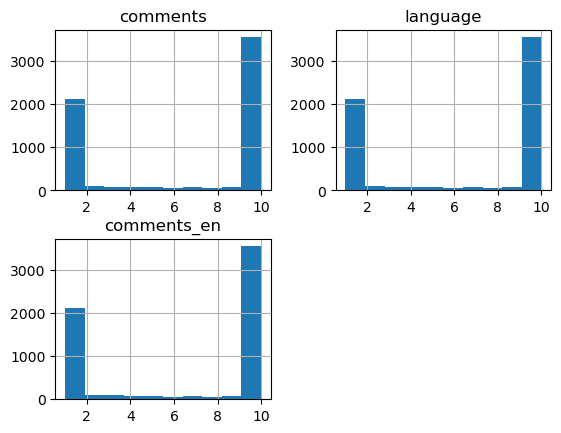

In [33]:
#count how many comments_en per index
df_10.groupby('index').count().hist()

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import pandas as pd
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [35]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

def clean(text_list):
    
    updates = []
    
    for j in tqdm(text_list):
        
        text = j
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        
        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        #Lemmatize
        text = " ".join(lemma.lemmatize(word) for word in text.split())
            
        updates.append(text)
        
    return updates

df_10['comments_en'] = clean(df_10['comments_en'])

  0%|          | 0/40644 [00:00<?, ?it/s]

In [36]:
df_10['comments_en'].head()

0                                     cozy comfortable house stay never worry safety host nice close parque metro station easy find
1                                                                         welcoming environment excellent location good value money
2                                                                                                     congratulation super indicate
3                                                                                                        great stay would recommend
4    cozy place good place stay clean organized everything sure close everything close subway make everything efficient recommended
Name: comments_en, dtype: object

In [37]:
import gensim.downloader

w2v = gensim.downloader.load('word2vec-google-news-300')

emb_size = 300

#function to get embeddings for each word based on w2v list
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in w2v.index_to_key:
                doc_vectors.append(w2v.get_vector(word))         
        corpus_vec.append(doc_vectors)
    return corpus_vec

df_10['comments_en'] = corpus2vec(df_10['comments_en'])


  0%|          | 0/40644 [00:00<?, ?it/s]

In [39]:
df_10

index  \
0          1   
1          1   
2          1   
3          1   
4          1   
...      ...   
40639   6248   
40640   6248   
40641   6248   
40642   6248   
40643   6248   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              comments  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         this is a very cozy and comfortable house to stay in.never worry about the safety and the host is very nice.very close to parque metro station.easy to find.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Ambiente acolhedor com uma localização excelente. Custo-benefício muito bom!   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Estão de parabéns super indico.   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Great stay! Would recommend   
4                                                                                                                                                                   

In [ ]:
#Each comment has a different number of words. Comment 5 has 17 words so it will be a list 17x300 vectors :)

In [40]:
#Now we want to average the word vectors for each comment to get a single vector that represents the entire comment

def average_vectors(vectors):
    if len(vectors) == 0:
        return np.zeros(emb_size)
    else:
        return np.mean(vectors, axis=0)

df_10['comments_en'] = df_10['comments_en'].apply(average_vectors)



In [41]:
print(df_10['comments_en'][4].shape)

(300,)


<Axes: >

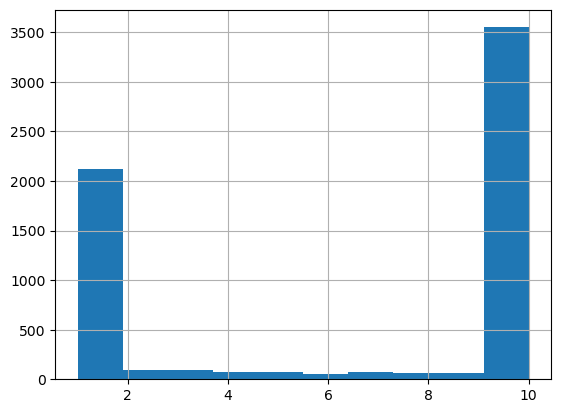

In [42]:
#guarantee that all indexes have the same number of commments (5)
df_10.groupby('index')["comments_en"].count().hist()

In [43]:
#Count the indexes that have less than 10 comments
df_10.groupby('index')["comments_en"].count().value_counts()


comments_en
10    3549
1     2116
2       92
3       89
4       75
7       73
5       69
9       67
8       60
6       58
Name: count, dtype: int64

In [44]:
#max index in our dataset
print(df_10['index'].max())

6248


In [ ]:
df_10.head()

,index,comments,language,comments_en,tag_count
0,1,this is a very cozy and comfortable house to stay in.never worry about the safety and the host is very nice.very close to parque metro station.easy to find.,en,"[0.0028422037, 0.013183594, -0.012734985, 0.101464845, -0.015549723, -0.0076293945, 0.016593425, -0.01624349, 0.088028975, 0.044803873, -0.01765747, -0.07783203, 0.009387207, -0.014718119, -0.10444336, 0.07124023, 0.07923177, 0.052107748, 0.01716868, -0.039453126, 0.07372487, 0.037410483, 0.006164551, 0.032454427, 0.0848877, 0.01850586, -0.05341797, 0.011685912, -0.0020345051, -0.13321127, -0.024798583, 0.0059733074, -0.020076497, -0.051032003, -0.022912597, -0.1286499, 0.027612304, -0.02212321, 0.022867838, 0.065079756, 0.0045084637, -0.089082845, 0.11622722, 0.004138184, -0.12473958, -0.0052042645, -0.04262085, 0.005818685, 0.02578125, 0.08474935, 0.0090861, 0.0725586, 0.06797155, -0.03999837, -0.03342692, -0.07585042, -0.03058281, -0.01102295, 0.06557617, -0.12145386, -0.053710938, 0.03995361, -0.12727255, -0.08961792, -0.0061442056, -0.023490397, -0.116463214, 0.07211914, -0.041560873, 0.13917847, 0.104083255, 0.07444661, 0.07327067, -0.03224284, -0.22236328, -0.016094971, 0.037475586, 0.037322998, 0.042657472, 0.13421224, -0.016866049, -0.005204773, 0.057191975, 0.035546876, -0.04876709, -0.0036132813, -0.11937764, 0.021146648, -0.00022786458, 0.02607422, 0.014137777, -0.037809245, -0.10466716, -0.06403605, -0.08089193, -0.02446289, 0.033289272, 0.00787557, 0.007191976, -0.116468556, ...]",NaN
1,1,Ambiente acolhedor com uma localização excelente. Custo-benefício muito bom!,pt,"[-0.02922712, 0.093030654, 0.015258789, 0.03374372, -0.04485212, 0.004817418, -0.0038800922, -0.0039585656, 0.059936523, 0.12011719, -0.035679407, -0.086120605, 0.032802038, 0.043561663, -0.035714287, 0.11453683, -0.030674526, 0.14630999, -0.010716029, -0.03227016, 0.037523814, 0.04513114, -0.04495675, 0.08925084, 0.025495257, -0.0066637313, -0.038140435, 0.085902624, 0.005126953, -0.10130528, -0.01511928, -0.1028268, 0.0073939734, 0.01461356, 0.066737585, -0.013340541, 0.03731864, -0.09262521, -0.05318778, -0.04497419, 0.084891185, -0.05232566, 0.06520735, 0.057364326, -0.13916016, -0.15115793, -0.0069492883, 0.12876675, -0.10362025, 0.014787947, 0.056012835, 0.056535993, 0.0066441125, -0.15529959, 0.004813058, 0.00793457, -0.060023718, -0.020113263, 0.13103376, -0.110829964, -0.08399309, 0.048182897, -0.21738108, -0.055454798, -0.016468594, -0.024518695, -0.050885882, -0.028547015, -0.06438337, 0.07672991, 0.0026768276, 0.00029645648, 0.15084402, -0.07495117, -0.059361048, -0.07474191, 0.048583984, 0.12679617, 0.09388951, 0.06844984, -0.0067313057, 0.0021563938, -0.028651645, 0.07498605, -0.02432687, -0.087786, -0.09465681, 0.10909598, 0.054399762, 0.087175645, 0.11701311, -0.035191126, -0.03945487, -0.06598772, -0.014264788, 0.0042550224, -0.080496654, 0.13689314, 0.056396484, -0.18802316, ...]",NaN
2,1,Estão de parabéns super indico.,pt,"[-0.12874348, -0.080078125, -0.015462239, 0.04711914, -0.062093098, -0.1336263, 0.07047526, -0.2565104, 0.07014974, 0.08492025, -0.13582356, -0.2105306, 0.0063323975, 0.14713542, 0.079427086, 0.20898438, -0.01969401, 0.15606181, -0.05826823, -0.053548176, 0.07739258, 0.15991211, 0.0065104165, -0.09851074, 0.10498047, -0.20532227, -0.084472656, 0.10078939, 0.10624186, 0.030517578, 0.004313151, -0.14778645, 0.08577474, 0.24316406, -0.1003418, 0.040364582, 0.04264323, 0.12467448, 0.023763021, 0.08943685, 0.05908203, -0.03434245, 0.19214122, 0.11279297, 0.09008789, -0.3216146, 0.04663086, 0.016698202, -0.119140625, -0.051798504, -0.028238932, 0.072265625, -0.060953777, 0.015625, -0.009592692, 0.28401694, -0.18961589, 0.0, -0.021809896, -0.03938802, -0.13378906, 0.11503092, -0.092684425, 0.04525757, 0.014160156, 0.1077474, -0.32584634, 0.16021729, -0.1315918, 0.16538493, -0.058453243, -0.11832682, 0.18025716, 0.10610962, -0.17447917, -0.07332357, 0.10473633, 0.16292317, 0.15234375, 0.10396322, -0.0018717448, 

In [ ]:
print(type(df_10))


<class 'pandas.core.frame.DataFrame'>


In [45]:
import pandas as pd
import numpy as np

# Define the shape of the vectors (assuming emb_size is defined)
vector_shape = (emb_size,)

# Group by 'index' and count the number of comments for each index
comments_count = df_10.groupby('index')['comments_en'].count()

# List to store dictionaries of rows to be appended
rows_to_append = []

# Iterate over each index that has less than 10 comments
for index, count in comments_count.items():
    if count < 10:
        # Calculate the number of zero vectors needed to reach 10 comments
        num_zero_vectors = 10 - count
        # Create zero vectors and append them to the list
        for _ in range(num_zero_vectors):
            rows_to_append.append({'index': index, 'comments_en': np.zeros(vector_shape)})

# Concatenate the list of dictionaries with the original DataFrame
df_10 = pd.concat([df_10, pd.DataFrame(rows_to_append)], ignore_index=True)

# Verify the counts after adding zero vectors
print(df_10.groupby('index')['comments_en'].count().value_counts())



comments_en
10    6248
Name: count, dtype: int64


In [46]:
print(type(df_10))

<class 'pandas.core.frame.DataFrame'>


In [47]:
unique_indexes = df_10['index'].unique()
print(unique_indexes)


[   1    2    3 ... 6246 6247 6248]


In [48]:
#Now I want to concatenate the comments_en for each index so that I have a single vector that represents all the comments for that index
df_10 = df_10.groupby('index')['comments_en'].apply(lambda x: np.concatenate(x.tolist())).reset_index()

In [49]:
df_10.head()

,index,comments_en
0,1,"[0.0028422037, 0.013183594, -0.012734985, 0.101464845, -0.015549723, -0.0076293945, 0.016593425, -0.01624349, 0.088028975, 0.044803873, -0.01765747, -0.07783203, 0.009387207, -0.014718119, -0.10444336, 0.07124023, 0.07923177, 0.052107748, 0.01716868, -0.039453126, 0.07372487, 0.037410483, 0.006164551, 0.032454427, 0.0848877, 0.01850586, -0.05341797, 0.011685912, -0.0020345051, -0.13321127, -0.024798583, 0.0059733074, -0.020076497, -0.051032003, -0.022912597, -0.1286499, 0.027612304, -0.02212321, 0.022867838, 0.065079756, 0.0045084637, -0.089082845, 0.11622722, 0.004138184, -0.12473958, -0.0052042645, -0.04262085, 0.005818685, 0.02578125, 0.08474935, 0.0090861, 0.0725586, 0.06797155, -0.03999837, -0.03342692, -0.07585042, -0.03058281, -0.01102295, 0.06557617, -0.12145386, -0.053710938, 0.03995361, -0.12727255, -0.08961792, -0.0061442056, -0.023490397, -0.116463214, 0.07211914, -0.041560873, 0.13917847, 0.104083255, 0.07444661, 0.07327067, -0.03224284, -0.22236328, -0.016094971, 0.037475586, 0.037322998, 0.042657472, 0.13421224, -0.016866049, -0.005204773, 0.057191975, 0.035546876, -0.04876709, -0.0036132813, -0.11937764, 0.021146648, -0.00022786458, 0.02607422, 0.014137777, -0.037809245, -0.10466716, -0.06403605, -0.08089193, -0.02446289, 0.033289272, 0.00787557, 0.007191976, -0.116468556, ...]"
1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
2,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
3,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]"
4,5,"[-0.060760498, -0.015220642, 0.028518677, 0.10058594, -0.084228516, -0.120666504, 0.10227966, -0.097839355, 0.088012695, 0.13554382, -0.033462524, -0.1116333, -0.035308838, -0.19909668, 0.18139648, 0.13916016, 0.015563965, -0.040649414, -0.008094788, -0.077301025, 0.024574757, 0.029296875, -0.030548096, 0.07324219, -0.060897827, -0.099853516, -0.031555176, 0.053741455, 0.13342285, -0.1494751, -0.10107422, 0.061828613, 0.06121826, 0.028686523, -0.080947876, 0.03060913, 0.018127441, -0.12487793, 0.041427612, 0.10046387, 0.06709671, -0.04260254, 0.17907715, 0.10626221, -0.013824463, -0.17443848, 0.05105591, -0.07476807, -0.017944336, 0.0026855469, -0.049438477, 0.064697266, 0.047729492, -0.1126709, -0.036254883, 0.0022583008, -0.03916931, -0.038635254, 0.116882324, -0.1449585, -0.060302734, -0.027389526, -0.17077637, -0.23046875, -0.060424805, -0.042541504, -0.10595703, -0.07312012, -0.07710266, 0.09164429, 0.045013428, 0.05340576, 0.14190674, 0.0015029907, -0.15362549, -0.028839111, -0.018981934, -0.09408569, 0.06237793, 0.005859375, -0.034179688, -0.044914246, 0.014312744, -0.100982666, 0.020965576, -0.

In [50]:
# Extract the lengths of each comment vector
comment_lengths = df_10['comments_en'].apply(len)

# Find the unique sizes
unique_sizes = comment_lengths.unique()

# Display the unique sizes
print("Unique sizes of comments_en:", unique_sizes)


Unique sizes of comments_en: [3000]


In [51]:
######PERFEITO CARALHOS MA FODAM


#pickle df_10
df_10.to_pickle('/Users/diogoparreira/Downloads/Project Corpora/train_reviews_10BEM.pkl')

In [52]:
#print one of the comments
print(df_10['comments_en'][0])


[ 0.0028422   0.01318359 -0.01273498 ... -0.015625    0.02403641
  0.18579102]


In [53]:
#size of it
print(df_10['comments_en'][0].shape)


(3000,)


In [54]:
#are the all the same 
print(df_10['comments_en'].apply(lambda x: x.shape).value_counts())

comments_en
(3000,)    6248
Name: count, dtype: int64


In [55]:
#upload the document
df_airbnb = pd.read_excel('/Users/diogoparreira/Downloads/Project Corpora/train.xlsx')
df_airbnb.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, with shared bathroom.<br />We are located right across the street from subway station Parque, we are 5 min walk to Marques de Pombal square.<br /><br /><b>The space</b><br />We offer woman only rooms, mixed rooms, double rooms, twins rooms, single rooms and family rooms. Our kitchen is open to all guests and There is a lounge for the guests to gather up, with cable TV. All rooms come standard equipped with comfortable beds, linen, blankets and reading lamps on side table. Free Wi-Fi access to all guests. Here you have no curfew, access is 24/7 and we have a late check out at 11:00, so you can sleep until late!<br /><br /><b>Guest access</b><br />All rooms have key-card access.",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII, Saldanha, estefanea, IST, Nova university ,. O meu espaço é bom para aventuras individuais.","I am friendly host, and I will try to always be around when you need anything. Though I'm quit strict with the house rules.",1
2,3,"Trafaria’s House is a cozy and familiar villa where you have all the facilities you need for your relaxing and comfortable holidays. It’s completely furnished and composed by 3 floors, 5 rooms, 3 living rooms, 3 bathrooms, two fully equipped kitchens and a garden where you may prepare a barbecue and feel at home. It’s ideal for large families. <br /> <br />It’s situated in a fishing quite village - Trafaria. It’s only 20 minutes away from Lisbon and 10 minutes from Costa da Caparica. <br /> <br />One can traverse the river Tagus by ferry or by car (or other means of transport) and acess Belém - the most typical area of Lisbon where history and tranquility are mixed, near several monuments everyone who visits this city must see, like Jerónimos Monastery (Mosteiro dos Jerónimos) - the greatest testimony of Manueline art, Belém Tower (Torre de Belém), Monument to the Discoveries (Padrão dos Descobrimentos), Cultural Centre of Belém (Centro cultural de Belém), the Carriage Museum (Museu","I am a social person liking to communicate, reading and travelling. I like cinema and theatre. But I am passionate about tourism. My goal is to show you Lisbon and Costa da Caparica, both side of river Tagus, making you feel at home!",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo do Carmo e a Travessa Trindade, Espaçoso, Cheio de Luz, Com Varanda ao Redor de toda a Casa. Ideal para Casal e com a Sofá Cama na Sala onde pode ficar um segundo Casal ou Filhos.<br /><br /><b>License number</b><br />91107/AL","Hello!_x000D_\nI m Portuguese and i love to meet people around the word, that s maybe one of the reason i decided to renew my single house to receive and meet you!",0
4,5,"Joli appartement en bordure de mer.<br /> 2 min. a pied de la plage.<br />Vue magnifique sur l’océan, 8e étage. Petit balcon<br />Chambres: un lit double, deux lits separés, salle de bains avec douche italienne, cuisine entièrement équipée, salon avec canapé lit.<br />Parking gratuit sur place, mini golf, restaurants, cafés. supermarché a disposition au bas de l'immeuble.<br /> A 40 km de Lisbonne, Proche de zones touristiques : parc a thème Dinopark, Obidos , Budhha Eden jardin oriental, l’ile de Berlengas,etc.<br /><br /><b>The space</b><br />logement totalement rénové . Vue magnifique sur l'océan.<br /><br /><b>License number</b><br />81300/AL",Nous sommes une famille avec deux enfants de 17 et 10 ans. Nous avons habité pendant plusieurs années au Portugal et aimerions vous faire connaître ce magnifique pays avec ses plages splendides et sa gastronomie excellente.,0


In [56]:
print(df_airbnb.shape)

(6248, 4)


In [57]:
#distribution of unlisted
df_airbnb['unlisted'].value_counts()

unlisted
0    4540
1    1708
Name: count, dtype: int64

In [58]:
#clean description and host about of html tags
from bs4 import BeautifulSoup

def clean_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

df_airbnb['description'] = df_airbnb['description'].apply(clean_html_tags)
df_airbnb['host_about'] = df_airbnb['host_about'].apply(clean_html_tags)

#check if there are any missing values
print(df_airbnb.isnull().sum())


/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_55284/387908967.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


index          0
description    0
host_about     0
unlisted       0
dtype: int64


In [59]:
df_airbnb.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, with shared bathroom.We are located right across the street from subway station Parque, we are 5 min walk to Marques de Pombal square.The spaceWe offer woman only rooms, mixed rooms, double rooms, twins rooms, single rooms and family rooms. Our kitchen is open to all guests and There is a lounge for the guests to gather up, with cable TV. All rooms come standard equipped with comfortable beds, linen, blankets and reading lamps on side table. Free Wi-Fi access to all guests. Here you have no curfew, access is 24/7 and we have a late check out at 11:00, so you can sleep until late!Guest accessAll rooms have key-card access.",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII, Saldanha, estefanea, IST, Nova university ,. O meu espaço é bom para aventuras individuais.","I am friendly host, and I will try to always be around when you need anything. Though I'm quit strict with the house rules.",1
2,3,"Trafaria’s House is a cozy and familiar villa where you have all the facilities you need for your relaxing and comfortable holidays. It’s completely furnished and composed by 3 floors, 5 rooms, 3 living rooms, 3 bathrooms, two fully equipped kitchens and a garden where you may prepare a barbecue and feel at home. It’s ideal for large families. It’s situated in a fishing quite village - Trafaria. It’s only 20 minutes away from Lisbon and 10 minutes from Costa da Caparica. One can traverse the river Tagus by ferry or by car (or other means of transport) and acess Belém - the most typical area of Lisbon where history and tranquility are mixed, near several monuments everyone who visits this city must see, like Jerónimos Monastery (Mosteiro dos Jerónimos) - the greatest testimony of Manueline art, Belém Tower (Torre de Belém), Monument to the Discoveries (Padrão dos Descobrimentos), Cultural Centre of Belém (Centro cultural de Belém), the Carriage Museum (Museu","I am a social person liking to communicate, reading and travelling. I like cinema and theatre. But I am passionate about tourism. My goal is to show you Lisbon and Costa da Caparica, both side of river Tagus, making you feel at home!",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo do Carmo e a Travessa Trindade, Espaçoso, Cheio de Luz, Com Varanda ao Redor de toda a Casa. Ideal para Casal e com a Sofá Cama na Sala onde pode ficar um segundo Casal ou Filhos.License number91107/AL","Hello!_x000D_\nI m Portuguese and i love to meet people around the word, that s maybe one of the reason i decided to renew my single house to receive and meet you!",0
4,5,"Joli appartement en bordure de mer. 2 min. a pied de la plage.Vue magnifique sur l’océan, 8e étage. Petit balconChambres: un lit double, deux lits separés, salle de bains avec douche italienne, cuisine entièrement équipée, salon avec canapé lit.Parking gratuit sur place, mini golf, restaurants, cafés. supermarché a disposition au bas de l'immeuble. A 40 km de Lisbonne, Proche de zones touristiques : parc a thème Dinopark, Obidos , Budhha Eden jardin oriental, l’ile de Berlengas,etc.The spacelogement totalement rénové . Vue magnifique sur l'océan.License number81300/AL",Nous sommes une famille avec deux enfants de 17 et 10 ans. Nous avons habité pendant plusieurs années au Portugal et aimerions vous faire connaître ce magnifique pays avec ses plages splendides et sa gastronomie excellente.,0


In [60]:
#create two new columns that will have the language of the description and host_about
df_airbnb['language_description'] = df_airbnb['description'].apply(lang_detect)
df_airbnb['language_host_about'] = df_airbnb['host_about'].apply(lang_detect)


In [65]:
from tqdm import tqdm
from googletrans import Translator

translator = Translator()

def translate_text(text):
    try:
        return translator.translate(text, dest='en').text
    except Exception as e:
        print(f"Translation failed for text: {text}")
        return 'error'

# Initialize a list to hold the translated descriptions
translated_descriptions = []

# Use tqdm to create a progress bar
for description, language in tqdm(zip(df_airbnb['description'], df_airbnb['language_description']), desc="Translating descriptions", total=len(df_airbnb)):
    if language != 'en':
        translated_descriptions.append(translate_text(description))
    else:
        translated_descriptions.append(description)

# Assign the translated descriptions to the new column
df_airbnb['description_en'] = translated_descriptions

# Print the translated descriptions
print(df_airbnb['description_en'])

# Check for any null values in the translated descriptions
null_count = df_airbnb['description_en'].isnull().sum()
print(f"Number of null translations: {null_count}")

# Repeat the same process for the host_about column
translated_host_abouts = []
for about, language in tqdm(zip(df_airbnb['host_about'], df_airbnb['language_host_about']), desc="Translating host_about", total=len(df_airbnb)):
    if language != 'en':
        translated_host_abouts.append(translate_text(about))
    else:
        translated_host_abouts.append(about)

# Assign the translated host_abouts to the new column
df_airbnb['host_about_en'] = translated_host_abouts

# Print the translated host_abouts
print(df_airbnb['host_about_en'])

# Check for any null values in the translated host_abouts
null_count_about = df_airbnb['host_about_en'].isnull().sum()
print(f"Number of null translations in host_about: {null_count_about}")




Translating descriptions: 100%|██████████| 6248/6248 [20:25<00:00,  5.10it/s]


0                                                                                                                                                                                                                                                                                                                      This is a shared mixed room in our hostel, with shared bathroom.We are located right across the street from subway station Parque, we are 5 min walk to Marques de Pombal square.The spaceWe offer woman only rooms, mixed rooms, double rooms, twins rooms, single rooms and family rooms. Our kitchen is open to all guests and  There is a lounge for the guests to gather up, with cable TV. All rooms come standard equipped with comfortable beds, linen, blankets and reading lamps on side table. Free Wi-Fi access to all guests. Here you have no curfew, access is 24/7 and we have a late check out at 11:00, so you can sleep until late!Guest accessAll rooms have key-card access.
1              

Translating host_about:   0%|          | 19/6248 [00:00<03:52, 26.85it/s]

Translation failed for text:  


Translating host_about:   1%|▏         | 86/6248 [00:08<12:43,  8.07it/s]

Translation failed for text: 



Translating host_about:   6%|▌         | 363/6248 [00:35<04:23, 22.35it/s]

Translation failed for text: DE
Mit Bookiply finden Sie ganz einfach Ihre perfekte Ferienunterkunft. Eine schöne Villa mit Bergblick an der Algarve? Ein gemütliches Apartment im Herzen von Albufeira oder ein Strandhaus an der goldenen Küste? Um Ihnen einen erholsamen Aufenthalt in den schönsten Regionen Portugals zu bieten, konzentrieren wir uns auf die Zusammenarbeit mit geprüften Gastgebern, deren Unterkünfte unseren hohen Qualitätskriterien entsprechen. Neben dem Fokus auf die Qualität, bieten wir einen Kundenservice, der Sie schnell und unkompliziert bei allen Fragen und Anliegen an sieben Tagen die Woche unterstützt.
************************************************************************

EN
With Bookiply you can easily find your perfect vacation rental. A beautiful villa with mountain views in the Algarve? A cozy apartment in the heart of Albufeira or a beach house by the golden coastline? To offer you a relaxing stay in Portugal’s most beautiful regions, we focus on working wit

Translating host_about:  12%|█▏        | 729/6248 [01:02<05:09, 17.83it/s]

Translation failed for text: 



Translating host_about:  13%|█▎        | 799/6248 [01:09<06:14, 14.56it/s]

Translation failed for text: 



Translating host_about:  14%|█▍        | 868/6248 [01:22<17:05,  5.25it/s]

Translation failed for text: Chamo-me José António e sou português, neste momento dedico-me ao turismo alugando  os meus apartamentos. Sou um excelente anfitrião e espero receber-vos na linda cidade de Lisboa. 


Translating host_about:  14%|█▍        | 871/6248 [01:22<19:15,  4.65it/s]

Translation failed for text: Eric é franco-português, cresceu em França, e eu sou parisiense, agora Lisboeta. 
Vivemos com os nossos filhos Mafalda 11 anos e Artur 10 anos. 
Também temos o Bobby, o nosso camião com quem viajamos um pouco pelo mundo. Titi nosso gato de 12 anos e Kawette nossa cadela de 7 anos. 
Vivemos no campo há 6 anos. E gradualmente construímos a nossa nova vida no meio da natureza. 
Nós gostamos muito de música, festivais e concertos. Eric é baterista e também DJ, eu canto e as crianças também. 
Viajar, cozinhar, caminhar, pedalar, andar, nadar, dançar. 
Também sou guia em Lisboa e adoro mostrar a nossa bela cidade.


Translating host_about:  14%|█▍        | 903/6248 [01:25<07:25, 12.01it/s]

Translation failed for text: DE
Mit Bookiply finden Sie ganz einfach Ihre perfekte Ferienunterkunft. Eine schöne Villa mit Bergblick an der Algarve? Ein gemütliches Apartment im Herzen von Albufeira oder ein Strandhaus an der goldenen Küste? Um Ihnen einen erholsamen Aufenthalt in den schönsten Regionen Portugals zu bieten, konzentrieren wir uns auf die Zusammenarbeit mit geprüften Gastgebern, deren Unterkünfte unseren hohen Qualitätskriterien entsprechen. Neben dem Fokus auf die Qualität, bieten wir einen Kundenservice, der Sie schnell und unkompliziert bei allen Fragen und Anliegen an sieben Tagen die Woche unterstützt.
************************************************************************

EN
With Bookiply you can easily find your perfect vacation rental. A beautiful villa with mountain views in the Algarve? A cozy apartment in the heart of Albufeira or a beach house by the golden coastline? To offer you a relaxing stay in Portugal’s most beautiful regions, we focus on working wit

Translating host_about:  14%|█▍        | 905/6248 [01:25<10:15,  8.68it/s]

Translation failed for text: Sou brasileira,  e moro em Portugal. Eu Arquiteta e meu marido Artista Plástico e Cozinheiro, estamos amando Lisboa. Uma cidade encantadora e cheia de lugares interessantes a serem desbravados. Gostamos de conhecer pessoas, e nos enriquecer com todas as culturas. Ficaremos muito felizes em receber na nossa casa!_x000D_
_x000D_
_x000D_
_x000D_
I am Brazilian, and I live in Portugal. I´m an Architect and my husband an Artist and Cook, we are loving Lisbon. A charming city full of interesting places to be explored. We like to meet people, and enrich ourselves with all cultures. We will be very happy to welcome you in our home!_x000D_
_x000D_



Translating host_about:  15%|█▍        | 908/6248 [01:26<13:02,  6.82it/s]

Translation failed for text: @ZMPoppe



Translating host_about:  15%|█▍        | 920/6248 [01:27<11:02,  8.04it/s]

Translation failed for text: Bem-vindos! Trabalhamos com hospedagens por curtas e longas estadias, durante todo o ano, em Lisboa e Almada. Nossos alojamentos são simples, práticos e económicos. Prezamos por um ambiente limpo, organizado e familiar. Quaisquer informações sobre estadias, nós estaremos disponíveis para atendê-los e recebê-los. Obrigada e saudações!


Translating host_about:  15%|█▌        | 941/6248 [01:30<09:38,  9.17it/s]

Translation failed for text: Olá, sou a Maria Guimarães, anfitriã das Casas da Biquinha. As 5 coisas sem as quais não consigo viver são a minha familia, os amigos mais chegados, um bom descanso, um bom banho e Sintra..._x000D_
_x000D_
Quem vier visitar as Casas da Biquinha, será recebido com toda a tenção que merece e irá sentir-se em casa. Pelos menos é isso que vou tentar transmitir._x000D_
_x000D_
Obrigada_x000D_
Maria Guimarães


Translating host_about:  15%|█▌        | 961/6248 [01:31<06:15, 14.09it/s]

Translation failed for text: Sou afavel , simpatica e sempre disponível


Translating host_about:  16%|█▌        | 971/6248 [01:31<06:13, 14.14it/s]

Translation failed for text: Somos uma família pequena que ama viajar, simpáticos e amigáveis.  Limpos e organizados. Zelamos sempre pelo respeito ao próximo. _x000D_
Só tivemos experiência positivas no Airbnb tanto como Hospedes tanto como  Anfitriões._x000D_
Amamos conhecer novas pessoas e fazer novos amigos.


Translating host_about:  16%|█▌        | 1007/6248 [01:34<04:43, 18.46it/s]

Translation failed for text: We are BmyGuest, a Short Term Rental company that manages more than 200 apartments for touristic, or business purposes. 

Our offer is in Lisbon, Oporto, Algarve and some Portugal special places. Outside of Portugal we also have apartments in Madrid and Paris.

We are ever-faithful lovers of Lisbon - the city in which we were born - of Portugal and of the World, and that’s why we enjoy touching the hearts of those who choose to visit us. And because Passion only makes sense when felt from both sides, it’s our guests that we strive to share it with, in each of the corners of our houses, in each decorative detail, in each view from a window overlooking the river, the sea or the city, and where nothing is left to chance.

That’s why the expression: Mi casa es su casa makes so much sense, becoming a universal imperative, valid in any language, for those that visit us from any corner of the Earth. And so our single mission: “to offer our guests the entire comfor

Translating host_about:  16%|█▋        | 1020/6248 [01:36<12:32,  6.95it/s]

Translation failed for text: I love nature, I'm vegetarian and keep a healthy and "nature care" lifestyle. I like living in Lisbon, this is very beautiful city that inspires me to create, to share. I would love to learn different languages, cultures, kitchen, I'm really open-minded person and I like traveling. I enjoy meeting new people and learning new things_x000D_
_x000D_
My family and friends are very important to me. I also appreciate music, culture and art. I admire people who value hard work and succeeding/achieving goals, yet at the same time embody humility._x000D_
_x000D_
I am artist who chose photography, performance and installation as privileged subjects of my artistic expression. Summing to that i developed a career in communications, production and brands activation._x000D_
_x000D_
If you wish to know more, let me know :)_x000D_
_x000D_
So I'm looking forward my new guests and I hope you enjoy your trip._x000D_
_x000D_
_x000D_
-GERM-_x000D_
_x000D_
Ich liebe die Natur, i

Translating host_about:  16%|█▋        | 1022/6248 [01:36<14:42,  5.92it/s]

Translation failed for text: Commentaire à venir...


Translating host_about:  16%|█▋        | 1027/6248 [01:38<16:47,  5.18it/s]

Translation failed for text: Uma pessoa viajada que sabe o quanto é importante ser bem recebido num local ou país estrangeiro. Uma pessoa que fará tudo o que estiver ao seu alcance para tornar a sua estadia mágica e inesquecível, incluindo indicações turísitcas, mapas e conselhos práticos para visitar esta maravilhosa cidade ou país!_x000D_
Quero que cada cliente passe a ser um amigo!


Translating host_about:  17%|█▋        | 1035/6248 [01:39<14:57,  5.81it/s]

Translation failed for text: O MEU LEMA DE VIDA E SER FELIZ, SOU SIMPÁTICA, AS PESSOAS NA NINHA CASA  SÃO SEMPRE BEM RECEBIDAS._x000D_
GOSTO MUITO DE VIAJAR DE PREFERÊNCIA DE AVIÃO ATE AGORA CONHEÇO  UM POUCO DA EUROPA._x000D_
GOSTO DO VERDE DA  NATUREZA , PRAIA.ENFIM VIVER EM LIBERDADE. _x000D_



Translating host_about:  17%|█▋        | 1042/6248 [01:40<14:32,  5.97it/s]

Translation failed for text: Wir sind ein Ehepaar (50 und 53 Jahre jung) aus Deutschland, leben aber schon einige Zeit im Ausland. Die letzten sechs Jahre haben wir auf Ibiza verbracht, wo wir bereits einige Erfahrungen mit der Vermietung unseres Hauses gemacht haben. _x000D_
_x000D_
Da Ibiza aber im Laufe der Zeit immer überlaufener und teurer wurde, sind wir Anfang 2017  ins schöne Portugal nach Bombarral gezogen. Hier bieten wir nun ebenfalls unser Haus gerne Gästen aus aller Welt als Ferienunterkunft an._x000D_
_x000D_
Wir empfangen alle unsere Gäste persönlich am Haus und da wir auch ganz in der Nähe wohnen, stehen wir ihnen gerne jederzeit mit Rat und Tat zur Verfügung.


Translating host_about:  17%|█▋        | 1062/6248 [01:42<12:24,  6.97it/s]

Translation failed for text: Sou Lisboeta e desportista. Sou economista e apaixonado por hotelaria há 8 anos. Falo Ingles, Grego, Francês e Italiano. Gosto de viajar e de contactar com outras culturas. _x000D_
_x000D_



Translating host_about:  17%|█▋        | 1068/6248 [01:43<16:04,  5.37it/s]

Translation failed for text: Psychologue scolaire , 41 ans, je suis mariée et j'ai deux enfants._x000D_
J'aime voyager, lire, apprendre. J'apprécie les expositions photos, le cinema et les bons restaurants._x000D_
Je serai ravie de vous accueillir dans ce studio, qui me sert de pied à terre quand je viens rendre visite à ma tante._x000D_
Ana, une personne de confiance habitant Lisbonne sera disponible pour vous aider sur place.


Translating host_about:  17%|█▋        | 1074/6248 [01:44<18:44,  4.60it/s]

Translation failed for text: _x000D_
_x000D_



Translating host_about:  17%|█▋        | 1080/6248 [01:46<18:43,  4.60it/s]

Translation failed for text: Sou o seu anfitrião em Lisboa, consultor imobiliário e gestor de short renting. Conhecedor profundo da cidade, pai de 2 filhos, gosto de música, em especial alternativa, de artes plásticas e performativas. Adoro Lisboa, cozinhar e receber pessoas.


Translating host_about:  17%|█▋        | 1086/6248 [01:46<11:58,  7.19it/s]

Translation failed for text: DE
Mit Bookiply finden Sie ganz einfach Ihre perfekte Ferienunterkunft. Eine schöne Villa mit Bergblick an der Algarve? Ein gemütliches Apartment im Herzen von Albufeira oder ein Strandhaus an der goldenen Küste? Um Ihnen einen erholsamen Aufenthalt in den schönsten Regionen Portugals zu bieten, konzentrieren wir uns auf die Zusammenarbeit mit geprüften Gastgebern, deren Unterkünfte unseren hohen Qualitätskriterien entsprechen. Neben dem Fokus auf die Qualität, bieten wir einen Kundenservice, der Sie schnell und unkompliziert bei allen Fragen und Anliegen an sieben Tagen die Woche unterstützt.
************************************************************************

EN
With Bookiply you can easily find your perfect vacation rental. A beautiful villa with mountain views in the Algarve? A cozy apartment in the heart of Albufeira or a beach house by the golden coastline? To offer you a relaxing stay in Portugal’s most beautiful regions, we focus on working wit

Translating host_about:  18%|█▊        | 1097/6248 [01:48<13:58,  6.15it/s]

Translation failed for text: STYLISTE/ARTISTE_x000D_
_x000D_
Vie l'instant présent !_x000D_
_x000D_
Films: Forest Jump, Les valseuses, o misterio de Lisboa, Pina Baush, In to the While, Les vies dansent_x000D_
_x000D_
Livres: _x000D_
Le pouvoir de l'instant présent, problème de Spinosa, La bibliographie d'un yogi, Le dernier jour d'un condamné...._x000D_
_x000D_
Voyages: Inde, jourdanie, Cap vert, Nigeria, Espagne, Angleterre, Italie, Autriche....._x000D_
_x000D_
Je voyage sans plan, au gré du vent,_x000D_
Sans montre, toujours prête à la rencontre,_x000D_
Je double ma curiosité, je capte la nouveauté !


Translating host_about:  18%|█▊        | 1104/6248 [01:49<11:56,  7.17it/s]

Translation failed for text: Bem vindos. Sou o André. Vivo em Lisboa há 23 anos e sou apaixonado por esta cidade, a sua luz, o rio, o casario e as pessoas. Farei tudo o que estiver ao meu alcance para lhe proporcionar uma boa estadia. _x000D_



Translating host_about:  18%|█▊        | 1124/6248 [01:51<11:53,  7.18it/s]

Translation failed for text: Je suis musicien et amoureux de la vie. Je suis plus heureux en compagnie d'amis. J'aime voyager, apprendre des langues et absorber des nouvelles cultures.


Translating host_about:  18%|█▊        | 1142/6248 [01:55<17:10,  4.96it/s]

Translation failed for text: Anfitrião profissional do airbnb 


Translating host_about:  18%|█▊        | 1149/6248 [01:56<15:28,  5.49it/s]

Translation failed for text: Brasileiro, naturalizado português, em lisboa a dez anos, de bem com a vida ,bem disposto e sempre disposto a dar atenção máxima para as necessidades das pessoas. 


Translating host_about:  18%|█▊        | 1152/6248 [01:57<24:55,  3.41it/s]

Translation failed for text: Carla Martins (NOOK AGENCY) 



Translating host_about:  19%|█▉        | 1172/6248 [01:59<10:19,  8.19it/s]

Translation failed for text: João's Apartments 


Translating host_about:  19%|█▉        | 1189/6248 [02:00<06:19, 13.33it/s]

Translation failed for text: Lisboeta, cidadão do mundo!_x000D_
Boa disposição e simpatia nunca são em demasia... 
adoro viajar conhecer novos sítios novas pessoas e também ter o prazer de depois mostrar a minha cidade aos meus amigos e os meus hóspedes.


Translating host_about:  19%|█▉        | 1210/6248 [02:03<11:03,  7.59it/s]

Translation failed for text: 



Translating host_about:  19%|█▉        | 1212/6248 [02:03<12:11,  6.88it/s]

Translation failed for text: DE
Mit Bookiply finden Sie ganz einfach Ihre perfekte Ferienunterkunft. Eine schöne Villa mit Bergblick an der Algarve? Ein gemütliches Apartment im Herzen von Albufeira oder ein Strandhaus an der goldenen Küste? Um Ihnen einen erholsamen Aufenthalt in den schönsten Regionen Portugals zu bieten, konzentrieren wir uns auf die Zusammenarbeit mit geprüften Gastgebern, deren Unterkünfte unseren hohen Qualitätskriterien entsprechen. Neben dem Fokus auf die Qualität, bieten wir einen Kundenservice, der Sie schnell und unkompliziert bei allen Fragen und Anliegen an sieben Tagen die Woche unterstützt.
************************************************************************

EN
With Bookiply you can easily find your perfect vacation rental. A beautiful villa with mountain views in the Algarve? A cozy apartment in the heart of Albufeira or a beach house by the golden coastline? To offer you a relaxing stay in Portugal’s most beautiful regions, we focus on working wit

Translating host_about:  20%|█▉        | 1220/6248 [02:04<11:36,  7.22it/s]

Translation failed for text: Designer profissional, mãe e amante de ar livre.


Translating host_about:  20%|█▉        | 1229/6248 [02:06<11:44,  7.12it/s]

Translation failed for text: Sempre vivi na zona do Estoril, espaço privilegiado pela sua beleza e calma.  A proximidade do mar permite-nos longos passeios junto à costa em qualquer estação do ano. Por outro lado, estamos muito perto de Lisboa e a viagem de comboio ou de carro é feita sempre lado a lado com o mar.  E, por isso, desejo poder proporcionar-vos uma boa estadia!


Translating host_about:  20%|█▉        | 1236/6248 [02:07<15:23,  5.43it/s]

Translation failed for text: Somos uma equipa multi-cultural e muito feliz!
Desejosos de dar as boas-vindas aos nossos hóspedes ao nosso extraordinário espaço da Quinta dos Lobos e oferecer-lhe uma experiência única, rodeada da Natureza e da história da nossa bonita Vila de Sintra.

We are a multi-cultural and happy team!
Eager to welcome our guests to our extraordinary space of Quinta dos Lobos and provide them with a unique experience, sorrounded by Nature and the history of the beautiful Vila of Sintra.


Translating host_about:  24%|██▎       | 1477/6248 [02:26<07:32, 10.54it/s]

Translation failed for text: 



Translating host_about:  27%|██▋       | 1705/6248 [02:45<06:16, 12.05it/s]

Translation failed for text: 



Translating host_about:  31%|███       | 1911/6248 [03:06<11:39,  6.20it/s]

Translation failed for text: 



Translating host_about:  31%|███       | 1943/6248 [03:12<21:40,  3.31it/s]

Translation failed for text: Não está disponível. Não consigo tirar o anúncio 


Translating host_about:  31%|███▏      | 1966/6248 [03:14<10:50,  6.59it/s]

Translation failed for text: Experiencia em navegação tanto profissionalmente como em lazer. Sou mergulhador certificado e pratico essa atividade como hobby.

Adoro viajar, conhecer novas pessoas e novas culturas. Sou verdadeiramente apaixonado pela nossa cidade e pelos encantos do Tejo.


Translating host_about:  32%|███▏      | 1972/6248 [03:15<13:01,  5.47it/s]

Translation failed for text: Marco lisboeta e Baptista francês. Apaixonados pela cidade de Lisboa, sobretudo o bairro da Graça com os seus lindíssimos miradouros com vista sobre o centro histórico e seus  restaurantes típicos. _x000D_
Adoramos viajar, descobrir lugares fora do comum e encontrar pessoas de outros horizontes e culturas. 


Translating host_about:  32%|███▏      | 1985/6248 [03:16<07:28,  9.51it/s]

Translation failed for text: Somos uma professora e um engenheiro. _x000D_
Adoramos viver junto do mar e da praia e perto de Lisboa,  Cascais e Sintra.


Translating host_about:  32%|███▏      | 1996/6248 [03:18<09:38,  7.35it/s]

Translation failed for text: Somos um casal de jovens arquitectos que decidiu seguir um sonho, reabilitar um imóvel em Lisboa... _x000D_
_x000D_
Adoramos viajar e como tal relacionar-nos com outras pessoas dos mais diferentes sítios, estamos ansiosos por te conhecer a ti também._x000D_
_x000D_



Translating host_about:  32%|███▏      | 2009/6248 [03:20<12:12,  5.79it/s]

Translation failed for text: Uma pessoa viajada que sabe o quanto é importante ser bem recebido num local ou país estrangeiro. Uma pessoa que fará tudo o que estiver ao seu alcance para tornar a sua estadia mágica e inesquecível, incluindo indicações turísitcas, mapas e conselhos práticos para visitar esta maravilhosa cidade ou país!_x000D_
Quero que cada cliente passe a ser um amigo!


Translating host_about:  33%|███▎      | 2041/6248 [03:23<07:44,  9.05it/s]

Translation failed for text: Sou feliz, pai de 2 filhos, gosto de trabalhar, estudar e viajar, conhecer novos lugares e novas pessoas e culturas.


Translating host_about:  33%|███▎      | 2059/6248 [03:25<06:06, 11.42it/s]

Translation failed for text: 



Translating host_about:  33%|███▎      | 2081/6248 [03:27<07:47,  8.92it/s]

Translation failed for text: Ola, sou o Vagner amo viajar,  trabalho bastante, ja estive em israel, praga, turquia, alguns lugares da europa, brasil e quero conhecer muito mais.


Translating host_about:  34%|███▎      | 2108/6248 [03:29<06:59,  9.86it/s]

Translation failed for text: 



Translating host_about:  34%|███▍      | 2110/6248 [03:30<10:19,  6.68it/s]

Translation failed for text: Somos brasileiros, vivíamos no Rio de Janeiro a maior parte da vida e agora estamos com a nossa família morando em Cascais!_x000D_
Abrimos o Alto do Estoril  pois gostamos de receber pessoas, conversar e fazer amigos!!_x000D_
Aqui faremos tudo para sua estadia ser inesquecível!!


Translating host_about:  34%|███▍      | 2129/6248 [03:32<09:24,  7.30it/s]

Translation failed for text: A Lisbon Property Management oferece serviços de gestão de propriedades no sector das estadias de curta duração (alojamento local/turismo). Todo o processo é tratado pela nossa equipa: desde a avaliação e colocação da propriedade online ao check-out e serviço de limpeza profissional._x000D_
_x000D_
_x000D_
_x000D_



Translating host_about:  34%|███▍      | 2141/6248 [03:33<06:39, 10.29it/s]

Translation failed for text: A Lisbon Property Management oferece serviços de gestão de propriedades no sector das estadias de curta duração (alojamento local/turismo). Todo o processo é tratado pela nossa equipa: desde a avaliação e colocação da propriedade online ao check-out e serviço de limpeza profissional._x000D_
_x000D_
_x000D_
_x000D_



Translating host_about:  35%|███▍      | 2172/6248 [03:35<05:23, 12.59it/s]

Translation failed for text: Tolerante, simpático, são duas das minhas principais caracteristicas.


Translating host_about:  35%|███▌      | 2197/6248 [03:37<04:58, 13.56it/s]

Translation failed for text: O verdadeiro descanso começa sempre que consegue equilibrar as áreas mais importantes da sua vida. O Quotidiano é o parceiro que entende as suas necessidades e que gere os seus assuntos. Ocupamo-nos e gerimos os mais variados serviços, em nome dos nossos clientes, procurando ajudá-los a recuperar tempo para si: propriedades, serviços domésticos, férias ou serviços administrativos, são apenas alguns exemplos. Afinal, o tempo será sempre o seu maior luxo. Deixe-o em boas mãos!_x000D_



Translating host_about:  35%|███▌      | 2204/6248 [03:39<07:27,  9.04it/s]

Translation failed for text: A smart studios foi criada em 2016 e oferece residências de co-living com studios e apartamentos num conceito all-inclusive para estudantes e profissionais.


Translating host_about:  36%|███▌      | 2222/6248 [03:42<06:51,  9.79it/s]

Translation failed for text: 52 anos. Economista. Casada. Mãe de 3 filhos. Residente em Arruda dos Vinhos e neste momento com disponibilidade total para acompanhar os nossos hóspedes.


Translating host_about:  36%|███▌      | 2227/6248 [03:44<14:57,  4.48it/s]

Translation failed for text: Adoro viajar, conhecer novas culturas e conviver com pessoas de outros países. Procuro viajar uma vez por ano para o Oriente. Prefiro Home Stays e Guest Houses, a hoteis, pois é a melhor forma de conhecer o povo de cada localidade e a sua cultura e também de fazer amigos pelo mundo fora. Por essa razão e porque gosto de receber bem, é com prazer que partilho a minha casa com os meus hóspedes, tentando sempre proporcionar-lhes uma estadia agradável  e memorável._x000D_
Adoro cozinhar para amigos e família, embora também o faça a nível profissional, num pequeno restaurante e bar de tapas de que sou sócia. _x000D_
A satisfação, bem estar e felicidade quer dos meus hóspedes, quer dos clientes para quem cozinho, é  o que me motiva e a minha principal recompensa e assim a lista de amigos de todo o mundo vai crescendo._x000D_
Também adoro arquitectura e design de interiores e eu própria sou decoradora._x000D_
Não posso viver sem a minha família, o meu cão, os meus

Translating host_about:  36%|███▌      | 2245/6248 [03:48<10:44,  6.21it/s]

Translation failed for text: Travel is life ! I love meeting people and helping them discover the amazing places I am lucky enough to call home in Portugal, Malta and the UK.  Maybe you will do as I did in 2009 and give up your old life to make one of these magical places home...

When travelling, I believe that paying to stay in a place is a real treat, and when you do so the very least that you should expect is for it to be as comfortable and clean as your own home, if not even better.  

For me, that means spaces that not only look amazing, but also cover the basics that are so often missing in AirBNB properties such as huge beds with fine linens and 100% blackout for a great nights sleep, plus Air Conditioning and Luxury amenities. 

It's these simple luxuries, plus sparkling clean places, great wifi / smart home tech and fast responsive service that I make sure to provide for my guests.

___

Les voyages c'est la vie ! J'aime rencontrer des gens et les aider à découvrir mon incroy

Translating host_about:  36%|███▌      | 2249/6248 [03:48<11:22,  5.86it/s]

Translation failed for text: Sediado e enraizado na Ericeira, o Grupo das Casas nasce em 2019 para consolidar uma história que começou há cerca de 20 anos com A Casa das Casas, a agência imobiliária mais acarinhada na região. Tendo como lema a mediação personalizada para cada cliente, conseguimos o melhor de dois mundos conciliando as vontades e pontos de vista de todos os intervenientes.

O Grupo das Casas entra agora em vários mercados onde a sua vocação encontra o seu valor acrescentado: viagens e alojamento local, avaliações e gestão de projetos, nanciamentos e comunidade e media.

Missão e valores: Temos 5 grandes valores que nos denem e norteiam a nossa forma de estar:

As Pessoas, a dimensão humana, as pessoas em primeiro lugar.
O Serviço. Uma forma de fazer negócio assente na proximidade e dedicação.
A Energia. Fazer sempre mais e melhor, com positivismo e paixão.
A Harmonia. Procuramos em cada momento o equilíbrio com uma atitude de conciliação entre os vários mundos.
A Ericei

Translating host_about:  36%|███▌      | 2255/6248 [03:49<09:20,  7.13it/s]

Translation failed for text: 



Translating host_about:  37%|███▋      | 2318/6248 [03:53<08:20,  7.85it/s]

Translation failed for text: Sou músico e no meu tempo livre gosto de surfar e estar em comunhão com a natureza.


Translating host_about:  37%|███▋      | 2325/6248 [03:56<19:31,  3.35it/s]

Translation failed for text: 5 coisas sem as quais não posso viver:_x000D_
- família_x000D_
- aviões_x000D_
- saúde_x000D_
- amor_x000D_
- alegria


Translating host_about:  38%|███▊      | 2355/6248 [04:01<10:36,  6.12it/s]

Translation failed for text: Sou uma pessoa dinâmica e extrovertida. Gosto de ler e de viajar. Não passo sem a minha família, sem os meus gatos, sem os meus livros e sem ser feliz. Gosto de viajar sem destino. O meu lema de vida é: "se não me mata torna me mais forte"._x000D_



Translating host_about:  38%|███▊      | 2358/6248 [04:03<17:25,  3.72it/s]

Translation failed for text: ¡ Expertos en la gestión de alquileres vacacionales y apasionados por el sector del turismo durante muchos años, nuestra agencia ofrece alojamiento de calidad que cumplirá con sus expectativas !_x000D_
Nuestro equipo internacional responderá a todas sus preguntas y lo asesorará durante la reserva._x000D_
_x000D_
Nuestro objetivo: ofrecerle unas vacaciones inolvidables y el deseo de volver._x000D_
_x000D_
------------------------------_x000D_
_x000D_
Spécialistes de la gestion de location de vacances et passionnés du secteur du tourisme depuis de nombreuses années, notre agence vous propose des logements de qualité qui sauront satisfaire vos attentes !_x000D_
Notre équipe d’ambassadeurs internationaux saura répondre à vos questions et vous accompagner tout au long de votre réservation._x000D_
_x000D_
Notre objectif : vous offrir des vacances réussies et l’envie de revenir !_x000D_
_x000D_



Translating host_about:  38%|███▊      | 2361/6248 [04:04<17:44,  3.65it/s]

Translation failed for text: Sou uma pessoa amigável, extrovertida e comunicativa. Brasileiro, há 5 anos em Portugal, apaixonado por essa terra encantadora. Fisioterapeuta e escritor que adora conhecer novas culturas e fazer amizades.


Translating host_about:  38%|███▊      | 2362/6248 [04:04<23:14,  2.79it/s]

Translation failed for text: We are french. We like bike and diving. We like also travel.


Translating host_about:  38%|███▊      | 2383/6248 [04:07<11:13,  5.74it/s]

Translation failed for text: Siempre me ha gustado crear ambientes bonitos para el deleite de mi familia y amigos. 
Hoy en día esa es mi actividad profesional. 
Republica do Sul nace para darme soporte y visibilidad en el mercado de la gestión de propiedades y orientarme al sector turismo ofreciendo alojamientos que harán que los huéspedes disfruten al máximo de su estancia. Esto último es conseguido tanto por los alojamientos, como por la oferta natural, cultural y se servicios de sus localizaciones.

Los últimos acontecimientos sociales nos han hecho centrar, más aún si cabe, los esfuerzos en la limpieza y desinfección para tranquilidad de todos nosotros ,clientes y huéspedes.

Espero siempre formar una bonita parte del recuerdo de sus vacaciones.


Translating host_about:  38%|███▊      | 2397/6248 [04:08<07:12,  8.91it/s]

Translation failed for text: DE
Mit Bookiply finden Sie ganz einfach Ihre perfekte Ferienunterkunft. Eine schöne Villa mit Bergblick an der Algarve? Ein gemütliches Apartment im Herzen von Albufeira oder ein Strandhaus an der goldenen Küste? Um Ihnen einen erholsamen Aufenthalt in den schönsten Regionen Portugals zu bieten, konzentrieren wir uns auf die Zusammenarbeit mit geprüften Gastgebern, deren Unterkünfte unseren hohen Qualitätskriterien entsprechen. Neben dem Fokus auf die Qualität, bieten wir einen Kundenservice, der Sie schnell und unkompliziert bei allen Fragen und Anliegen an sieben Tagen die Woche unterstützt.
************************************************************************

EN
With Bookiply you can easily find your perfect vacation rental. A beautiful villa with mountain views in the Algarve? A cozy apartment in the heart of Albufeira or a beach house by the golden coastline? To offer you a relaxing stay in Portugal’s most beautiful regions, we focus on working wit

Translating host_about:  39%|███▊      | 2406/6248 [04:10<12:34,  5.09it/s]

Translation failed for text: Siempre me ha gustado crear ambientes bonitos para el deleite de mi familia y amigos. 
Hoy en día esa es mi actividad profesional. 
Republica do Sul nace para darme soporte y visibilidad en el mercado de la gestión de propiedades y orientarme al sector turismo ofreciendo alojamientos que harán que los huéspedes disfruten al máximo de su estancia. Esto último es conseguido tanto por los alojamientos, como por la oferta natural, cultural y se servicios de sus localizaciones.

Los últimos acontecimientos sociales nos han hecho centrar, más aún si cabe, los esfuerzos en la limpieza y desinfección para tranquilidad de todos nosotros ,clientes y huéspedes.

Espero siempre formar una bonita parte del recuerdo de sus vacaciones.


Translating host_about:  39%|███▊      | 2410/6248 [04:11<14:39,  4.36it/s]

Translation failed for text: 我是一名来自中国的朋友，广交世界好友，请大家多多指教,希望能给大家带来舒适,温暖,干净,整洁的居住环境,让您有家一般的感受,祝您旅途愉快!最好的问候!


Translating host_about:  39%|███▊      | 2411/6248 [04:12<19:46,  3.24it/s]

Translation failed for text: De culture franco-portugaise, je suis une passionnée d'immobilier._x000D_
Je m'intéresse également au développement durable et à pleins d'autres choses._x000D_
Je parle plusieurs langues français, anglais, portugais, allemand, espagnol._x000D_
Pour nos vacances, nous louons également chez des particuliers et cela enrichit notre savoir-faire pour que nos vacanciers soient satisfaits de leur séjour._x000D_



Translating host_about:  42%|████▏     | 2647/6248 [04:34<05:15, 11.42it/s]

Translation failed for text: DE
Mit Bookiply finden Sie ganz einfach Ihre perfekte Ferienunterkunft. Eine schöne Villa mit Bergblick an der Algarve? Ein gemütliches Apartment im Herzen von Albufeira oder ein Strandhaus an der goldenen Küste? Um Ihnen einen erholsamen Aufenthalt in den schönsten Regionen Portugals zu bieten, konzentrieren wir uns auf die Zusammenarbeit mit geprüften Gastgebern, deren Unterkünfte unseren hohen Qualitätskriterien entsprechen. Neben dem Fokus auf die Qualität, bieten wir einen Kundenservice, der Sie schnell und unkompliziert bei allen Fragen und Anliegen an sieben Tagen die Woche unterstützt.
************************************************************************

EN
With Bookiply you can easily find your perfect vacation rental. A beautiful villa with mountain views in the Algarve? A cozy apartment in the heart of Albufeira or a beach house by the golden coastline? To offer you a relaxing stay in Portugal’s most beautiful regions, we focus on working wit

Translating host_about:  44%|████▎     | 2720/6248 [04:40<03:41, 15.89it/s]

Translation failed for text: 



Translating host_about:  44%|████▍     | 2748/6248 [04:43<03:38, 16.01it/s]

Translation failed for text: 



Translating host_about:  45%|████▌     | 2813/6248 [04:47<03:34, 15.98it/s]

Translation failed for text: 



Translating host_about:  51%|█████▏    | 3204/6248 [05:14<03:32, 14.30it/s]

Translation failed for text: DE
Mit Bookiply finden Sie ganz einfach Ihre perfekte Ferienunterkunft. Eine schöne Villa mit Bergblick an der Algarve? Ein gemütliches Apartment im Herzen von Albufeira oder ein Strandhaus an der goldenen Küste? Um Ihnen einen erholsamen Aufenthalt in den schönsten Regionen Portugals zu bieten, konzentrieren wir uns auf die Zusammenarbeit mit geprüften Gastgebern, deren Unterkünfte unseren hohen Qualitätskriterien entsprechen. Neben dem Fokus auf die Qualität, bieten wir einen Kundenservice, der Sie schnell und unkompliziert bei allen Fragen und Anliegen an sieben Tagen die Woche unterstützt.
************************************************************************

EN
With Bookiply you can easily find your perfect vacation rental. A beautiful villa with mountain views in the Algarve? A cozy apartment in the heart of Albufeira or a beach house by the golden coastline? To offer you a relaxing stay in Portugal’s most beautiful regions, we focus on working wit

Translating host_about:  52%|█████▏    | 3252/6248 [05:21<17:29,  2.86it/s]

Translation failed for text: Empresário de Hoteleria y Restaurasion,ingeniero fisico de profesion.


Translating host_about:  53%|█████▎    | 3320/6248 [05:27<07:30,  6.50it/s]

Translation failed for text: Sou uma pessoa dinamica que gosta de conhecer novas pessoas de diferentes culturas


Translating host_about:  53%|█████▎    | 3322/6248 [05:27<10:11,  4.79it/s]

Translation failed for text: Pessoa calma, bem humorada e tranquila. Adoro viajar, ler, passear praia, música e vida familiar. Não gosto de vícios nem de vida noturna. Gosto de conhecer diferentes culturas. 


Translating host_about:  54%|█████▎    | 3347/6248 [05:32<13:01,  3.71it/s]

Translation failed for text: Tornar-me anfitriã do Airbnb é neste momento um desafio e uma oportunidade para desenvolver, ainda mais, uma actividade que já venho exercendo, há dois anos, em outro site que considero um sucesso e mesmo um  privilégio. Gostaria de dar a conhecer os meus alojamentos a novos viajantes, proporcionando-me também a oportunidade de dar a conhecer a região, onde resido, neste lindo país que é Portugal, onde o clima é ameno, a comida boa, com muitos e bons restaurantes, onde o mar e a serra se interligam nas suas lindas paisagens naturais e  as belas e límpidas praias. _x000D_



Translating host_about:  54%|█████▎    | 3348/6248 [05:32<16:32,  2.92it/s]

Translation failed for text: Somos uma empresa de aluguer e administração de imóveis em Lisboa que preza pela qualidade dos serviços e atendimento personalizado para cada um dos nossos hóspedes. Connosco terá a certeza de ser recebido com carinho,  sempre em apartamentos de alto nível, novos ou renovados, equipados com cuidado e bom gosto. _x000D_
Fazer com que sinta-se em casa é o nosso objetivo. _x000D_
_x000D_
We are a short-rental company based in Lisbon, Portugal.  Our goal is to assure high quality services to all of our guests. With Libest you will feel welcomed, hosted with care, always in high-leveled, brand new or renovated apartments, well equipped, comfortable and with good taste. _x000D_
Our mission is to make you feel home.


Translating host_about:  55%|█████▍    | 3424/6248 [05:37<03:37, 12.97it/s]

Translation failed for text: Gosto de viajar e de conviver.
Translation failed for text: Jovem lisboeta, anfitrião para todos os que queiram conhecer o que Lisboa tem de melhor a oferecer, sempre disponível para lhe ajudar durante a sua estadia


Translating host_about:  55%|█████▌    | 3447/6248 [05:40<05:47,  8.07it/s]

Translation failed for text: O verdadeiro descanso começa sempre que consegue equilibrar as áreas mais importantes da sua vida. O Quotidiano é o parceiro que entende as suas necessidades e que gere os seus assuntos. Ocupamo-nos e gerimos os mais variados serviços, em nome dos nossos clientes, procurando ajudá-los a recuperar tempo para si: propriedades, serviços domésticos, férias ou serviços administrativos, são apenas alguns exemplos. Afinal, o tempo será sempre o seu maior luxo. Deixe-o em boas mãos!_x000D_



Translating host_about:  55%|█████▌    | 3459/6248 [05:41<04:16, 10.88it/s]

Translation failed for text: Família_x000D_
Portugal_x000D_
Gavião_x000D_
música_x000D_
passeios 
Translation failed for text: Gostamos de receber hóspedes e proporcionar-lhes experiências  no decorrer da  sua estadia. 
Recebemos todo o tipo de pessoas. 
Aconselhamos que respeitem os hábitos, usos e costumes, das gentes locais, a autenticidade dos lugares e  as tradições locais.





Translating host_about:  55%|█████▌    | 3461/6248 [05:43<08:30,  5.46it/s]

Translation failed for text: Happy couple.


Translating host_about:  56%|█████▌    | 3473/6248 [05:44<06:49,  6.77it/s]

Translation failed for text: Madalena Orquídea Living nasce da reabilitação criteriosa
de um edifício da baixa pombalina, na Rua da Madalena.
A prioridade será sempre a de representar a essência da alma
lisboeta no seu melhor.


Translating host_about:  56%|█████▌    | 3478/6248 [05:45<07:06,  6.49it/s]

Translation failed for text: Desenhei esta casa a pensar no que gostaria de encontrar, se fosse um viajante que viesse à descoberta de Lisboa. Um misto de conforto que me fizesse sentir em casa e uma colecção de objectos que falassem de uma forma de viver diferente, que contassem histórias. Espero que gostem; e regressem.     


Translating host_about:  56%|█████▌    | 3493/6248 [05:46<05:56,  7.73it/s]

Translation failed for text: Boa pessoa. Fiável e honesto.


Translating host_about:  56%|█████▌    | 3501/6248 [05:49<09:12,  4.98it/s]

Translation failed for text: Olá chamo-me João Mário Ribeiro tenho 36 anos de idade, nasci e fui criado em Lisboa. Sou formado em Arquitetura, e decidi-me tornar num anfitrião da Airbnb, divido à minha grande paixão de conhecer pessoas novas e viajar pelo mundo. _x000D_
Desta forma terei a fantástica oportunidade de me colocar no outro lado, de receber viajantes de todo o mundo, e conseguir mostrar e transmitir da melhor forma um pouco das vivencias da minha cidade...


Translating host_about:  56%|█████▌    | 3503/6248 [05:49<10:28,  4.37it/s]

Translation failed for text: Esta é uma actividade da família._x000D_
Carlos Antunes – Gosto de vida ao ar livre em especial tudo o que relacione com o mar desporto preferido a Vela._x000D_
Uma manha de vela e um bom almoço de peixe fresco e está o dia perfeito. ._x000D_
Benvinda Antunes – é o motor da família, sempre pronta a resolver todos os problemas, prefere ter os pés na terra._x000D_
Nuno Antunes – 23 anos estudante finalista em gestão não dispensa diariamente o treino de canoagem na modalidade de surfski_x000D_



Translating host_about:  56%|█████▌    | 3504/6248 [05:50<13:37,  3.36it/s]

Translation failed for text: Com experiência no mercado hoteleiro e turístico, tenho como objetivo poder proporcionar uma estadia agradável e memorável a todos os viajantes via airbnb através deste fantástico apartamento._x000D_
_x000D_



Translating host_about:  56%|█████▌    | 3507/6248 [05:51<13:12,  3.46it/s]

Translation failed for text: Tudo de Bom


Translating host_about:  56%|█████▌    | 3510/6248 [05:52<12:54,  3.54it/s]

Translation failed for text: Olá. Sou a Teresa, arquitecta e grande apaixonada por Lisboa. Tenho uma casa fantástica que acabei de remodelar num estilo "vintage", já a pensar num novo desafio que desde sempre me entusiasmou: receber hóspedes, amigos e amigos de amigos, curiosos em conhecer e explorar esta cidade linda, que é Lisboa!_x000D_
Uma cidade com muita história e histórias, onde se respira cultura, degusta-se gastronomia de excelência, onde é possível ouvir e sentir a intensidade da vida nesta cidade e simultaneamente, a paz de tantos recantos com vista para o rio. Uma cidade bela moldada por 7 colinas abraçadas por duas serras “lá ao longe” que transformam toda esta pequena zona do País, deslumbrante._x000D_



Translating host_about:  56%|█████▋    | 3516/6248 [05:52<09:12,  4.95it/s]

Translation failed for text: Somos um casal  educado, simpático e bem disposto. Adoramos viajar, motas, caravanas, praia e sol. Somos pais de 2 rapazes que já saíram de casa e nos deixaram 2 quartos e uma sala vazios. Por isso resolvemos abrir as nossas portas a viajantes educados simpáticos e bem dispostos que queiram conhecer Cascais, Sintra e Lisboa. Temos imensas sugestões para dar e estamos totalmente disponíveis para ajudar no que precisar.  


Translating host_about:  57%|█████▋    | 3532/6248 [05:53<05:04,  8.91it/s]

Translation failed for text: Bem vindos. Sou o André. Vivo em Lisboa há 23 anos e sou apaixonado por esta cidade, a sua luz, o rio, o casario e as pessoas. Farei tudo o que estiver ao meu alcance para lhe proporcionar uma boa estadia. _x000D_

Translation failed for text: Como apaixonado pela vida sinto prazer em tudo o que faço. O alojamento local faz parte da minha vida desde a herança das casas dos meus avós que sempre achei que seriam bem usadas recebendo os visitantes da bonita cidade de Évora, onde nasci e fui criado. Conto com a ajuda incondicional da minha mãe, Maria do Céu, super anfitriã!_x000D_
_x000D_
Sou financeiro de profissão e a  minha maior paixão são os cavalos, aos quais dedico todos os meus tempos livres e que bastante já me fizeram viajar e conhecer pessoas.


Translating host_about:  57%|█████▋    | 3543/6248 [05:56<06:26,  7.00it/s]

Translation failed for text: 超级三脚猫


Translating host_about:  57%|█████▋    | 3558/6248 [05:57<05:31,  8.10it/s]

Translation failed for text: Lisboa é a cidade da minha vida e eu quero partilhá-la convosco!_x000D_
Sejam bem vindos...


Translating host_about:  57%|█████▋    | 3564/6248 [05:58<06:23,  7.00it/s]

Translation failed for text: Somos um casal dedicado cada um à sua profissão, jornalista e nutricionista, mas com um gosto em comum: o turismo. Adoramos viajar e conhecer novas culturas, este ano resolvemos entrar numa nova aventura e abrimos as portas do nosso apartamento Sunrise Cascais Bay para todos aqueles que querem conhecer e usufruir dos encantos de cascais, sintra e todo o distrito de lisboa. Fotografia é uma das nossas paixões e esta é uma zona rica em fantásticas paisagens: vista mar, vista montanha, museus, palácios , castelos e muito mais. Para aqueles que gostam de desportos de mar e vento, a Praia do Guincho (5 minutos de carro) oferece as condições perfeitas. Por outro lado, em cascais encontra várias praias tranquilas, com águas calmas, boas para relaxar e nadar.


Translating host_about:  57%|█████▋    | 3578/6248 [06:00<10:27,  4.25it/s]

Translation failed for text: Olá, o meu nome é  Ana. Sempre vivi no Estoril, que adoro. Tenho o privilegio de morar num locais mais bonitos so mundo.


Translating host_about:  57%|█████▋    | 3579/6248 [06:01<10:19,  4.31it/s]

Translation failed for text: 



Translating host_about:  58%|█████▊    | 3595/6248 [06:03<06:07,  7.22it/s]

Translation failed for text: Adoro praia, mar,sol o meu filho e o meu marido


Translating host_about:  58%|█████▊    | 3608/6248 [06:04<04:16, 10.30it/s]

Translation failed for text: Jovens rapazes dinâmicos simpáticos divertidos e humildes, que gostam de viajar e conhecer novos lugares, pessoas._x000D_
Gostamos de praticar desporto, ir ao cinema, quando viajamos costumamos hospedar em Hostels, Hoteis e Airbnb, depende das viagens e da companhia.


Translating host_about:  58%|█████▊    | 3616/6248 [06:05<05:22,  8.16it/s]

Translation failed for text: Olá!! Sou brasileiro, actualmente vivo e trabalho em Lisboa, sou músico profissional, sou uma pessoa tranquila, simpático e comunicativo, gosto de tratar o máximo possível bem os meus clientes, a minha casa é abençoada e todos que entra nela serão abençoado. 

Hello!! I am Brazilian, currently alive and working in Lisbon, I am a professional musician, I am a quiet person, friendly and communicative, I like to treat my customers as well as possible, my house is blessed and everyone who enters it will be blessed.


Translating host_about:  58%|█████▊    | 3650/6248 [06:08<05:13,  8.28it/s]

Translation failed for text: Olá!_x000D_
 Gosto de ser comunicative, estou disponível para ajudar em tudo que for preciso... Eu tenho um apartamento que tem 6 quartos no total! _x000D_
Bem-vindo em Lisboa, estou à sua espera!_x000D_
_x000D_
Hello!_x000D_
 I like to be communicative, I am available to help in everything I need...I have an apartment that has 6 rooms in total! _x000D_
Welcome in Lisbon, I'm waiting for you!


Translating host_about:  59%|█████▊    | 3666/6248 [06:10<05:32,  7.77it/s]

Translation failed for text: Ich bin der Besitzer vom Da Silva Surfcamp in Portugal, Praia da Areia Branca, in der Nähe von Peniche.


Translating host_about:  59%|█████▊    | 3668/6248 [06:10<07:37,  5.64it/s]

Translation failed for text: Ola, sou o Vagner amo viajar,  trabalho bastante, ja estive em israel, praga, turquia, alguns lugares da europa, brasil e quero conhecer muito mais.


Translating host_about:  59%|█████▉    | 3687/6248 [06:13<07:26,  5.73it/s]

Translation failed for text: Wie alles in Lissabon begann...

Im Jahre 1991 begann eine sehr glückliche portugiesisch-deutsche Beziehung während der dreijährigen Ausbildung zur Reiseverkehrskauffrau/mann in Berlin. Nach erfolgreichem Abschluss folgten mehrere Jahre mit wertvollen Erfahrungen bei Spezialreiseveranstaltern in Berlin und Lissabon. Acht Jahre später nahmen wir das Angebot unseres Lissabonner Freundes an, seine Wohnung in Lapa zu kaufen. Nach beendeter Sanierung und individueller Einrichtung verbrachten wir regelmäßig mit unserer kleinen Tochter die Wintermonate in Lissabon. Während dieser Zeit beschäftigten wir uns viel mit der Restaurierung von Antiquitäten, historischen Bauelementen und Designobjekten.

Viele Freunde und Gäste besuchten unsere Wohnung und so stellte sich bald die Frage nach einer Erweiterung. 2005 konnten wir von unserem ehemaligen Apotheker Senhor Pereira, der aus Altersgründen sein Geschäft aufgab, das Altstadthaus in São Vicente / Alfama erwerben. Wie

Translating host_about:  59%|█████▉    | 3701/6248 [06:15<06:50,  6.20it/s]

Translation failed for text: Adoro gatos, o mar, as pessoas..._x000D_
A Casa e o Mundo é o nosso ponto de partida para um projecto mais global. Esta casa será um porto de abrigo para quem queira conhecer Cascais e as suas gentes e nós conhecermos o mundo._x000D_
A Casa e o Mundo quer promover algumas iniciativas mais locais mas também internacionais, no Verão podemos pensar em ciclos de cinema no pátio, jantares temáticos, tertúlias, encontros de músicos, etc._x000D_
A Casa é também um local de repouso e recuperação temos alguns serviços de saúde que oferecemos como massagem Pressel, massagem ayurvedica e de recuperação._x000D_
Ofertas personalizadas  de passeios por Lisboa, Sintra e Cascais._x000D_
Aulas de piano._x000D_
_x000D_
Pessoalmente trabalho como massagista Pressel numa equipa interdisciplinar de medicina antroposófica- Equipa Ephésus._x000D_
 (Website hidden by Airbnb) _x000D_
_x000D_
Sempre que tenho tempo livre adoro passá-lo na natureza em caminhadas pelo campo, passeios 

Translating host_about:  59%|█████▉    | 3710/6248 [06:16<05:00,  8.44it/s]

Translation failed for text: Jovem lisboeta, anfitrião para todos os que queiram conhecer o que Lisboa tem de melhor a oferecer, sempre disponível para lhe ajudar durante a sua estadia


Translating host_about:  59%|█████▉    | 3713/6248 [06:16<05:53,  7.18it/s]

Translation failed for text: Edad 56 anos
Me gusta playa e campo


Translating host_about:  60%|█████▉    | 3731/6248 [06:18<05:17,  7.94it/s]

Translation failed for text: Sou português, vivo em Lisboa e gosto muito de viajar sempre acompanhando de família ou amigos. 


Translating host_about:  60%|█████▉    | 3737/6248 [06:19<05:03,  8.27it/s]

Translation failed for text: Criada por uma equipa amante de design._x000D_
_x000D_
A PortugalHosting (PTH) é uma marca criada para um projecto de desenvolvimento de novos apartamentos de design que permitem aos hóspedes desfrutar de uma típica realidade e arredores combinada com detalhes contemporâneos de decoração._x000D_
_x000D_
Você amará a cidade e o projecto PortugalHosting!_x000D_
_x000D_
------------------------------------------//-----------------------------------------------_x000D_
_x000D_
Created by a design team._x000D_
_x000D_
PortugalHosting (PTH) is a brand created to develop a project that prepares and manages design apartments allowing its guests to enjoy a typical reality combined with contemporary details of decoration and materials._x000D_
_x000D_
You will love PortugalHosting project!_x000D_



Translating host_about:  60%|██████    | 3764/6248 [06:23<07:35,  5.46it/s]

Translation failed for text: Sou um jovem lisboeta que adora o relacionamento com pessoas . É com muito gosto que estou no airbnb . Farei tudo o que estiver ao meu alcance para que todos os anfitriões tenham uma óptima estadia . 


Translating host_about:  60%|██████    | 3766/6248 [06:23<08:58,  4.61it/s]

Translation failed for text: _x000D_



Translating host_about:  60%|██████    | 3769/6248 [06:25<11:40,  3.54it/s]

Translation failed for text: Sou a Tânia 


Translating host_about:  61%|██████    | 3793/6248 [06:26<04:56,  8.27it/s]

Translation failed for text: A Moradia localizada no Centro da Vila Franca 2 minutos da Estacão de Comboio apenas 25minutos dirigindo de Lisboa, próximo a tudo; Neo-realismo, Museu, Mercado Municipal, Restaurantes, Bares, Lojas, Supermercados, Hospital etc. tudo que necessita em um só (Website hidden by Airbnb) interior e exterior com decorações antigas; lindos azulejos Portugueses decorando as paredes das escadas com piso de madeira original , imóvel dispõe  quartos com banheiro privado, confortável cama de casal e sofa bed ideal para máximo três pessoas, temos disponível microwave ,refrigerador, tostadora e utensílios alem de  smart Tv e internet grátis...
Family Home Lisboa Quarto/Sala 1. Localizado rede chão, Quarto/Sala 2. Localizado Primeiro piso
, Quarto, Sala e Varanda Quarto 3. Localizado Primeiro piso

Estamos dispostos a fazer com que sua estadia seja ótima por isso estamos disponíveis para lhe hospedar e ajudar no que for possível !
Estamos localizado em uma excelente area 

Translating host_about:  61%|██████    | 3809/6248 [06:28<05:38,  7.19it/s]

Translation failed for text: .


Translating host_about:  62%|██████▏   | 3852/6248 [06:33<05:53,  6.77it/s]

Translation failed for text: Jovens rapazes dinâmicos simpáticos divertidos e humildes, que gostam de viajar e conhecer novos lugares, pessoas._x000D_
Gostamos de praticar desporto, ir ao cinema, quando viajamos costumamos hospedar em Hostels, Hoteis e Airbnb, depende das viagens e da companhia.


Translating host_about:  63%|██████▎   | 3928/6248 [06:41<07:08,  5.41it/s]

Translation failed for text: Love to smile! Love nature! Love travelling!


Translating host_about:  64%|██████▍   | 3987/6248 [06:45<05:13,  7.22it/s]

Translation failed for text: Somos uma família que vive para o turismo mas também uma família que viaja muito e sabe o que é estar do outro lado, É por isso que os nossos hóspedes são mais do que clientes, mas amigos! LxRoller&Allover - Tourism no (Hidden by Airbnb) ! (Website hidden by Airbnb)


Translating host_about:  65%|██████▍   | 4039/6248 [06:50<02:21, 15.56it/s]

Translation failed for text: 



Translating host_about:  66%|██████▌   | 4107/6248 [06:56<05:28,  6.51it/s]

Translation failed for text: Sou finalista do Mestrado em Engenharia do Ambiente em Lisboa, gosto muito de estar com os meus amigos e viajar. Sou natural do Brasil e vivo em Lisboa há 15 anos . Neste momento estou a tentar empreender nesta area de alojamento local . Sou bastante acessível e encontrei no airbnb uma oportunidade para uma nova forma de ganhar dinheiro para investir no meu sonho , que é contribuir para que a nossa qualidade de vida no planeta não seja alterada . Sejam bem vindos para conhecer alguns dos meus alojamentos , eu não vivo em nenhum deles , mas tenho uma equipe de pessoas me ajudam manter tudo bem organizado , espero apenas que desfrutem .


Translating host_about:  66%|██████▋   | 4145/6248 [07:00<04:16,  8.21it/s]

Translation failed for text: Português amigável nascido e criado em Lisboa, que gosta de viajar e conhecer pessoas :)


Translating host_about:  66%|██████▋   | 4152/6248 [07:02<06:52,  5.08it/s]

Translation failed for text: Família_x000D_
Portugal_x000D_
Gavião_x000D_
música_x000D_
passeios 


Translating host_about:  67%|██████▋   | 4164/6248 [07:03<04:36,  7.53it/s]

Translation failed for text: Meriteluna é uma marca registada e detida pela empresa portuguesa Ombala Unipessoal, Lda., fundada in 2019.

O nome “Ombala” surge da descendência Umbundo, grupo étnico de Angola, de um dos sócios, cujo significado é “palácio”, e reforça a ideia de nos esforçarmos para oferecer aos nossos hóspedes a qualidade de alojamento dos palácios portugueses e o calor humano dos palácios angolanos (Ombalas).

As nossas propriedades oferecem espaços amplos e acolhedores com objectivo de proporcionar todo conforto que os viajantes necessitam nas suas estadias, sem prescindir do que é essencial.

Todas propriedades possuem um padrão de qualidade único e minimalista, facilmente reconhecível. Estão bem equipadas e estrategicamente localizadas para permitir uma rápida deslocação para as zonas mais cosmopolitas de Lisboa, Sintra e Cascais.

As propriedades estão localizadas em zonas de clima ameno, perto das estações de comboio, metropolitano, vias rápidas ou autoestradas.



Translating host_about:  67%|██████▋   | 4173/6248 [07:05<04:40,  7.40it/s]

Translation failed for text: Os espaços Al-Hamma Apartment&Suites , estão localizados no coração de Lisboa, no bairro de Alfama, o mais antigo e típico desta cidade.  Numa localização estratégica para que possa conhecer os mais importantes monumentos  a pé e com uma vasta rede de transportes a poucos metros. A sua estadia será uma experiência única e memorável.


Translating host_about:  68%|██████▊   | 4255/6248 [07:14<06:12,  5.34it/s]

Translation failed for text: We are a family with 2 young children and have returned to Hamburg/Germany in the meantime. We had been assigned to Lisbon for a few years and came to love the city.
Here on AirBnB, the Magickey team helps us to manage our newly refurbished Lisbon house. Welcome to LX!
(And please submit a rating after your stay, we need it!)

Wir sind eine Familie mit 2 kleinen Kindern und leben mittlerweile wieder in Hamburg/Deutschland. Einige Jahre waren wir beruflich nach Lissabon entsendet und haben während des Aufenthalts die Stadt lieb gewonnen.
Hier auf AirBnB hilft uns das Magickey Team dabei, unser neu renoviertes Haus zu verwalten. Willkommen in LX!
(Und bitte erstellt nach Eurem Aufenthalt eine Bewertung für uns, wir brauchen sie!)

Somos uma família com 2 miúdos pequenos e entretanto regressamos a Hamburgo/Alemanha. Estivemos em Lisboa uns anos por razões profissionais e ficamos apaixonados pela cidade.
Aqui no AirBnB a equipa da Magickey ajuda-nos a gerir a n

Translating host_about:  68%|██████▊   | 4257/6248 [07:16<08:57,  3.71it/s]

Translation failed for text: sss


Translating host_about:  70%|██████▉   | 4370/6248 [07:22<02:35, 12.08it/s]

Translation failed for text: Olá! 
Sou a Catarina, nascida e criada em Lisboa. 
Sou terapeuta de Saúde e Bem-Estar,Saúde Alternativa,  Ayurveda, Holística e SPA.
Adoro conhecer pessoas de outras culturas e partilhar a minha. 
Amo viajar, e quando o faço gosto de ser bem recebida, com acolhimento e conforto. 
E é esse o meu compromisso para quem aqui fica hospedado, no meu ninho :)
E estarei sempre disponível para vos dar a conhecer melhor a minha cidade,  e dicas sobre o que de melhor aqui há. :))
Sejam Bem-vindos !


Translating host_about:  70%|███████   | 4404/6248 [07:28<06:01,  5.11it/s]

Translation failed for text: _x000D_
I love to travel, meet new people and other cultures. I'm a lover of sport: golf, tennis, surfing, etc. I like good food, with special emphasis for the Portuguese cuisine. I love music!_x000D_
I am an economist and professor at the University of Lisbon, expert in real estate finance. I'm real estate appraiser accredited by RICS and the author and co-author of three books, two of which on real estate investments._x000D_
My roots are in the Montes da Senhora, a village in the interior of Portugal, in the District of Castelo Branco, less than 2 hours drive from Lisbon. That's where I grew up and that's where I'm going now, some times, to enjoy the silence of the countryside, the singing of birds, the excellent local gastronomy, the beautiful walks and bike rides, for sharming hills and valleys,  and, not least, of healthy conviviality with the good people of the village._x000D_
And so I'm sure will be for you a unique experience, I invite you to spend 

Translating host_about:  71%|███████   | 4416/6248 [07:31<08:45,  3.49it/s]

Translation failed for text: A Pro Touristic é uma empresa com mais de 15 anos de experiência profissional com desempenho de funções em vários países - Portugal, Moçambique, Estados Unidos da América. Especialista em operações turísticas e hoteleiras.


Translating host_about:  71%|███████▏  | 4465/6248 [07:34<01:46, 16.81it/s]

Translation failed for text: Sou a Marta, vivo em Lisboa, cidade onde nasci, sou empresária, tenho 3 filhos, adoro fazer yoga e viajar sempre que consigo!


Translating host_about:  73%|███████▎  | 4543/6248 [07:42<03:33,  8.00it/s]

Translation failed for text: Love host


Translating host_about:  73%|███████▎  | 4586/6248 [07:50<08:14,  3.36it/s]

Translation failed for text: A Alojoeste adora bem receber, primoramos por uma boa experiência em que estamos disponíveis para qualquer dúvida ou dificuldade. Tudo para que as suas férias sejam fantásticas!


Translating host_about:  74%|███████▎  | 4594/6248 [07:52<07:55,  3.48it/s]

Translation failed for text: Simpática, alegre e divertida, sempre disponível_x000D_
_x000D_
Friendly, cheerful and fun, always available_x000D_
_x000D_
Agradable, alegre y divertido, siempre disponible_x000D_
_x000D_
Agréable, heureux et amusant, toujours disponible_x000D_



Translating host_about:  74%|███████▍  | 4610/6248 [07:53<03:00,  9.08it/s]

Translation failed for text: Olá!! Sou brasileiro, actualmente vivo e trabalho em Lisboa, sou músico profissional, sou uma pessoa tranquila, simpático e comunicativo, gosto de tratar o máximo possível bem os meus clientes, a minha casa é abençoada e todos que entra nela serão abençoado. 

Hello!! I am Brazilian, currently alive and working in Lisbon, I am a professional musician, I am a quiet person, friendly and communicative, I like to treat my customers as well as possible, my house is blessed and everyone who enters it will be blessed.


Translating host_about:  74%|███████▍  | 4612/6248 [07:54<04:10,  6.53it/s]

Translation failed for text: Olá!_x000D_
Estamos sempre disponíveis em qualquer das nossas casas para vos receber.


Translating host_about:  74%|███████▍  | 4624/6248 [07:55<02:45,  9.81it/s]

Translation failed for text: Olá! Chamo-me Cláudia Diniz e sou responsável pela empresa CheckinHome - Rental management & Business Solutions._x000D_
Sou uma pessoa cheia de boa energia, simpática, honesta e responsável. Temos uma equipa dinâmica e pronta a assegurar aos hóspedes uma estadia muito acolhedora, por isso sinta-se à vontade para solicitar algo que possa não estar descrito. Será certamente disponibilizado. Esperamos a sua visita. Até breve! 


Translating host_about:  74%|███████▍  | 4628/6248 [07:56<04:35,  5.89it/s]

Translation failed for text: Mafalda e Luís
Somos um casal de Criadores, proprietários do Econature Dagaio.


Econature Dagaio, é um espaço único e exclusivo no coração da Ericeira
Totalmente handmade pelos dois proprietários. Uma história que respira Arte e Conforto em todos os espaços.

Entre as Casas e Estúdios, Lagos naturais, Areais, Grutas e Jardins, respire Arte em cada recanto (desde a decoração, móveis, esculturas, lagos naturais ) 

Econature Dagaio é 100% criado e feito pelas nossas mãos com muito Amor e Carinho.

EconatureDagaio é um lugar mágico, onde as emoções fluem de dentro para fora de portas. A Arte mistura-se com o som da natureza e o cheiro da brisa do Mar.

Sejam Bem-Vindos!



Translating host_about:  74%|███████▍  | 4636/6248 [07:57<03:23,  7.94it/s]

Translation failed for text: Person enjoying life :)


Translating host_about:  74%|███████▍  | 4637/6248 [07:58<04:50,  5.54it/s]

Translation failed for text: Ola ! O meu nome e claudia miranda! Sou advogada de profissão! Adoro viajar e ter contacto com novas pessoas de vários países e culturas ! Sou bastante comunicativa e gosto de dar a conhecer o que Lisboa e arredores tem de melhor para oferecer ! 


Translating host_about:  75%|███████▍  | 4671/6248 [08:01<02:54,  9.04it/s]

Translation failed for text: French guy living in Lisbon and in love with this beautiful city. _x000D_
I speak English. Je parle français. Falo português._x000D_
I am looking forward to welcoming nice and friendly guests._x000D_
Living in the same building, I will make sure that you enjoy your stay in Lisbon and really want to come back._x000D_
_x000D_
Français habitant Lisbonne et amoureux de cette belle ville._x000D_
Je suis impatient d'accueillir de sympathiques voyageurs._x000D_
Habitant dans le même immeuble, je m'assurerai que vous apprecierez votre séjour à Lisbonne et que vous souhaiterez y revenir.


Translating host_about:  75%|███████▌  | 4690/6248 [08:03<03:12,  8.11it/s]

Translation failed for text:  


Translating host_about:  75%|███████▌  | 4717/6248 [08:06<03:52,  6.59it/s]

Translation failed for text: Vivo em  Lisboa e no Brasil, e gosto de receber pessoas em minha casa!!_x000D_
Adoro Lisboa e gosto de viajar. _x000D_
Espero que gostem tanto da casa como eu e que disfrutem ao máximo da nossa encantadora cidade! 


Translating host_about:  76%|███████▌  | 4727/6248 [08:07<03:37,  7.01it/s]

Translation failed for text: Sou uma pessoa comunicativa, com forte capacidade de socialização, prova disso é o facto de viver num País diferente do meu mas ainda assim sentir -me integrada... mas também sei ser tranquila e reservada, gosto de que respeitem a minha privacidade/liberdade. Como é que isso se aplica aos meus hóspedes? Simples... vou estar sempre disposta a trocar ideais sobre vários temas bem como orienta-los no que for preciso, quando estiver em casa, ao mesmo tempo que saberei deixar-lhes a vontade, respeitado a sua privacidade. Na minha casa opto por manter as zonas comuns sempre limpas organizadas...Por norma durante o dia não estou  em casa, por razões profissionais, mas sempre estou on-line para qualquer ajuda.... aliás deixo tudo organizado para que o hóspede tenha só facilidade! 


Translating host_about:  76%|███████▌  | 4750/6248 [08:11<03:09,  7.90it/s]

Translation failed for text: Com vontade de fazer mais e melhor..._x000D_
Disponível para ajudar os meus hóspedes a terem uma magnífica estadia em Lisboa...


Translating host_about:  77%|███████▋  | 4789/6248 [08:15<02:30,  9.67it/s]

Translation failed for text: Resido no Rio há mais de 30 anos. Casado e pai de dois filhos jovens. Adoro viajar e conhecer novos lugares. Tenho prazer em receber e hospedar pessoas e compartilhar com elas as belezas da cidade maravilhosa. Agora, terei prazer também em recebê-los na encantadora cidade de Lisboa, Portugal.



Translating host_about:  77%|███████▋  | 4830/6248 [08:20<05:07,  4.61it/s]

Translation failed for text: Mi piacere viaggiare conoscere diverse culture, studiare ed approfondire la conoscenza. Mi piace il cinema, il nuoto, fare amicizie._x000D_



Translating host_about:  78%|███████▊  | 4857/6248 [08:22<03:27,  6.69it/s]

Translation failed for text:  


Translating host_about:  78%|███████▊  | 4862/6248 [08:24<05:15,  4.40it/s]

Translation failed for text: DE
Mit Bookiply finden Sie ganz einfach Ihre perfekte Ferienunterkunft. Eine schöne Villa mit Bergblick an der Algarve? Ein gemütliches Apartment im Herzen von Albufeira oder ein Strandhaus an der goldenen Küste? Um Ihnen einen erholsamen Aufenthalt in den schönsten Regionen Portugals zu bieten, konzentrieren wir uns auf die Zusammenarbeit mit geprüften Gastgebern, deren Unterkünfte unseren hohen Qualitätskriterien entsprechen. Neben dem Fokus auf die Qualität, bieten wir einen Kundenservice, der Sie schnell und unkompliziert bei allen Fragen und Anliegen an sieben Tagen die Woche unterstützt.
************************************************************************

EN
With Bookiply you can easily find your perfect vacation rental. A beautiful villa with mountain views in the Algarve? A cozy apartment in the heart of Albufeira or a beach house by the golden coastline? To offer you a relaxing stay in Portugal’s most beautiful regions, we focus on working wit

Translating host_about:  78%|███████▊  | 4872/6248 [08:26<04:28,  5.12it/s]

Translation failed for text: Wie alles in Lissabon begann...

Im Jahre 1991 begann eine sehr glückliche portugiesisch-deutsche Beziehung während der dreijährigen Ausbildung zur Reiseverkehrskauffrau/mann in Berlin. Nach erfolgreichem Abschluss folgten mehrere Jahre mit wertvollen Erfahrungen bei Spezialreiseveranstaltern in Berlin und Lissabon. Acht Jahre später nahmen wir das Angebot unseres Lissabonner Freundes an, seine Wohnung in Lapa zu kaufen. Nach beendeter Sanierung und individueller Einrichtung verbrachten wir regelmäßig mit unserer kleinen Tochter die Wintermonate in Lissabon. Während dieser Zeit beschäftigten wir uns viel mit der Restaurierung von Antiquitäten, historischen Bauelementen und Designobjekten.

Viele Freunde und Gäste besuchten unsere Wohnung und so stellte sich bald die Frage nach einer Erweiterung. 2005 konnten wir von unserem ehemaligen Apotheker Senhor Pereira, der aus Altersgründen sein Geschäft aufgab, das Altstadthaus in São Vicente / Alfama erwerben. Wie

Translating host_about:  79%|███████▊  | 4920/6248 [08:31<03:02,  7.26it/s]

Translation failed for text: DE
Mit Bookiply finden Sie ganz einfach Ihre perfekte Ferienunterkunft. Eine schöne Villa mit Bergblick an der Algarve? Ein gemütliches Apartment im Herzen von Albufeira oder ein Strandhaus an der goldenen Küste? Um Ihnen einen erholsamen Aufenthalt in den schönsten Regionen Portugals zu bieten, konzentrieren wir uns auf die Zusammenarbeit mit geprüften Gastgebern, deren Unterkünfte unseren hohen Qualitätskriterien entsprechen. Neben dem Fokus auf die Qualität, bieten wir einen Kundenservice, der Sie schnell und unkompliziert bei allen Fragen und Anliegen an sieben Tagen die Woche unterstützt.
************************************************************************

EN
With Bookiply you can easily find your perfect vacation rental. A beautiful villa with mountain views in the Algarve? A cozy apartment in the heart of Albufeira or a beach house by the golden coastline? To offer you a relaxing stay in Portugal’s most beautiful regions, we focus on working wit

Translating host_about:  79%|███████▉  | 4937/6248 [08:33<02:13,  9.84it/s]

Translation failed for text: DE
Mit Bookiply finden Sie ganz einfach Ihre perfekte Ferienunterkunft. Eine schöne Villa mit Bergblick an der Algarve? Ein gemütliches Apartment im Herzen von Albufeira oder ein Strandhaus an der goldenen Küste? Um Ihnen einen erholsamen Aufenthalt in den schönsten Regionen Portugals zu bieten, konzentrieren wir uns auf die Zusammenarbeit mit geprüften Gastgebern, deren Unterkünfte unseren hohen Qualitätskriterien entsprechen. Neben dem Fokus auf die Qualität, bieten wir einen Kundenservice, der Sie schnell und unkompliziert bei allen Fragen und Anliegen an sieben Tagen die Woche unterstützt.
************************************************************************

EN
With Bookiply you can easily find your perfect vacation rental. A beautiful villa with mountain views in the Algarve? A cozy apartment in the heart of Albufeira or a beach house by the golden coastline? To offer you a relaxing stay in Portugal’s most beautiful regions, we focus on working wit

Translating host_about:  79%|███████▉  | 4940/6248 [08:34<02:57,  7.35it/s]

Translation failed for text: Somos uma família de Lisboa e adoramos viver nesta cidade. Gostamos muito de viajar, fazer desporto, principalmente desportos mais radicais, adoramos a gastronomia e experimentar bons vinhos!
Estamos sempre prontos para os receber, e gostamos  de dar dicas sobre a nossa cidade e outras partes do nosso país.


Translating host_about:  79%|███████▉  | 4947/6248 [08:35<02:37,  8.24it/s]

Translation failed for text: Nice guy.


Translating host_about:  80%|████████  | 5025/6248 [08:42<01:27, 14.05it/s]

Translation failed for text: Sou Pai, sou chefe de família, sou amigo, sou tímido e sonhador. 
Gosto de viajar, viagem de sonho Amazónia. 
O que já fiz: plantei uma árvore, fiz um filho, só me falta escrever o livro.
Lema de vida: Faz bem não olhes a quem!


Translating host_about:  81%|████████  | 5066/6248 [08:46<02:17,  8.58it/s]

Translation failed for text: Tenho 63 anos e sou reformado por invalidez. Sou casado e vivo na Ericeira ( a vila mais linda do mundo). Tenho várias casas de família e amigos para alugar. Faça uma visita em website  maisericeira com
Falo Português, Francês, Inglês e Espanhol.
Apoio todos os turistas que nos visitam
Seriá um grande prazer recebê-lo e darei todo o apoio que precisar.
Estou disponível para providenciar:
- transporte de e para o aeroporto,
- Aluguer de carros,
- aluguer de bicicletas / scooters e equipamento de surf,
- Visitas guiadas,
- Referência de escola de surf.
- Passeios de barco ao longo da costa da Ericeira
- Serviços e entrega de flores e mercearias.
Gosto de música (the Queens...), comer e desporto.
estou sempre no PC
------------------------------------------------------------------------------------------
I rent houses for anyone who wants to visit Ericeira.  
I’m 63 years old and retired due to being handicapped.  I’m married and I live in Ericeira (the world’

Translating host_about:  81%|████████▏ | 5089/6248 [08:48<01:16, 15.23it/s]

Translation failed for text: Alojamento Santa Catarina - Alenquer_x000D_
Local acolhedor e familiar, no centro da Vila de Alenquer a 20 minutos de Lisboa._x000D_
Estacionamento privado, WI-FI, TV e terraço._x000D_
Junto ao Parque Urbano da Romeira, fácil acesso a transportes públicos.


Translating host_about:  82%|████████▏ | 5140/6248 [08:55<02:47,  6.60it/s]

Translation failed for text: j'aime les paisagem la montagne et tout qui c'est loisir. 


Translating host_about:  83%|████████▎ | 5166/6248 [08:57<02:04,  8.69it/s]

Translation failed for text: Je suis Architecte depuis 25 ans et j ai des bureaux a Paris, et  LISBONNE._x000D_
Depuis 2009 ans je dessine une collection de mobilier contemporain, AZEA que je produit au Portugal et que je vends partout en Europe pour le moment: (Website hidden by Airbnb) _x000D_
J adore les voyages, l art contemporain et tout ce qui est en rapport avec la création:  sculpture , design , architecture, mode , ..._x000D_
Je serai ravi de vous recevoir a Lisbonne , j adore discuter avec les gens et je parle 5 langues : portugais , français , anglais , espagnol et italien .


Translating host_about:  83%|████████▎ | 5175/6248 [08:59<02:19,  7.67it/s]

Translation failed for text: DE
Mit Bookiply finden Sie ganz einfach Ihre perfekte Ferienunterkunft. Eine schöne Villa mit Bergblick an der Algarve? Ein gemütliches Apartment im Herzen von Albufeira oder ein Strandhaus an der goldenen Küste? Um Ihnen einen erholsamen Aufenthalt in den schönsten Regionen Portugals zu bieten, konzentrieren wir uns auf die Zusammenarbeit mit geprüften Gastgebern, deren Unterkünfte unseren hohen Qualitätskriterien entsprechen. Neben dem Fokus auf die Qualität, bieten wir einen Kundenservice, der Sie schnell und unkompliziert bei allen Fragen und Anliegen an sieben Tagen die Woche unterstützt.
************************************************************************

EN
With Bookiply you can easily find your perfect vacation rental. A beautiful villa with mountain views in the Algarve? A cozy apartment in the heart of Albufeira or a beach house by the golden coastline? To offer you a relaxing stay in Portugal’s most beautiful regions, we focus on working wit

Translating host_about:  84%|████████▎ | 5227/6248 [09:05<03:20,  5.10it/s]

Translation failed for text: Sou Damaris 


Translating host_about:  84%|████████▍ | 5239/6248 [09:08<04:22,  3.84it/s]

Translation failed for text:  


Translating host_about:  84%|████████▍ | 5244/6248 [09:09<03:29,  4.79it/s]

Translation failed for text: Chamo Martins tenho 36 anos, gosto de conhecer pessoas e lugares... 


Translating host_about:  84%|████████▍ | 5250/6248 [09:10<03:52,  4.30it/s]

Translation failed for text: De coração lisboeta, nasci em Paris, vivi alguns anos no centro de Portugal e vivo em Lisboa à mais de 10anos, lugar onde adoro viver._x000D_
Sou arquitecta de formação, faço alguns trabalhos de arquitectura mas dedico grande parte do meu tempo a receber os meus hóspedes e fazer de tudo para que tenham uma excelente estadia e experiência em Lisboa.


Translating host_about:  85%|████████▍ | 5297/6248 [09:13<01:27, 10.88it/s]

Translation failed for text: Residência no Brasil com casa em Portugal


Translating host_about:  87%|████████▋ | 5418/6248 [09:21<00:42, 19.39it/s]

Translation failed for text: 



Translating host_about:  87%|████████▋ | 5424/6248 [09:23<01:55,  7.15it/s]

Translation failed for text: Host in Lisboa at Casa Amarela Belém.


Translating host_about:  87%|████████▋ | 5430/6248 [09:24<02:39,  5.13it/s]

Translation failed for text: Bem-vindos! Trabalhamos com hospedagens por curtas e longas estadias, durante todo o ano, em Lisboa e Almada. Nossos alojamentos são simples, práticos e económicos. Prezamos por um ambiente limpo, organizado e familiar. Quaisquer informações sobre estadias, nós estaremos disponíveis para atendê-los e recebê-los. Obrigada e saudações!


Translating host_about:  87%|████████▋ | 5432/6248 [09:25<03:09,  4.32it/s]

Translation failed for text: De lisboa e gosto de desportos maritimos


Translating host_about:  87%|████████▋ | 5447/6248 [09:27<03:34,  3.74it/s]

Translation failed for text: Sara & Hugo: Jovem casal, com atividade profissional na área financeira. Gostam de viajar e praticar desportos ao ar livre.
Iniciaram este projeto de alojamento local para receber os hóspedes como gostam de ser recebidos nas suas viagens. 


Translating host_about:  87%|████████▋ | 5466/6248 [09:29<01:55,  6.74it/s]

Translation failed for text: Apaixonada por Portugal!


Translating host_about:  88%|████████▊ | 5471/6248 [09:32<03:55,  3.30it/s]

Translation failed for text: Chamo-me José António e sou português, neste momento dedico-me ao turismo alugando  os meus apartamentos. Sou um excelente anfitrião e espero receber-vos na linda cidade de Lisboa. 


Translating host_about:  88%|████████▊ | 5476/6248 [09:33<04:08,  3.11it/s]

Translation failed for text: Soy un cubano  afincado en Portugal y adora Lisboa, al que le gusta conocer gente y compartir sus experiencias en esta ciudad con los visitantes para que acaben enamorados de ella._x000D_
 


Translating host_about:  88%|████████▊ | 5480/6248 [09:35<04:38,  2.75it/s]

Translation failed for text: A Alojoeste adora bem receber, primoramos por uma boa experiência em que estamos disponíveis para qualquer dúvida ou dificuldade. Tudo para que as suas férias sejam fantásticas!


Translating host_about:  88%|████████▊ | 5482/6248 [09:35<04:37,  2.76it/s]

Translation failed for text: Somos uma empresa de aluguer e administração de imóveis em Lisboa que preza pela qualidade dos serviços e atendimento personalizado para cada um dos nossos hóspedes. Connosco terá a certeza de ser recebido com carinho,  sempre em apartamentos de alto nível, novos ou renovados, equipados com cuidado e bom gosto. _x000D_
Fazer com que sinta-se em casa é o nosso objetivo. _x000D_
_x000D_
We are a short-rental company based in Lisbon, Portugal.  Our goal is to assure high quality services to all of our guests. With Libest you will feel welcomed, hosted with care, always in high-leveled, brand new or renovated apartments, well equipped, comfortable and with good taste. _x000D_
Our mission is to make you feel home.


Translating host_about:  88%|████████▊ | 5483/6248 [09:36<05:42,  2.24it/s]

Translation failed for text: Sou empresária no ramo de hotelaria ._x000D_
Sempre trabalhei com o público e adoro o que faço._x000D_
Ser anfitrião do Airbnb é um verdadeiro  e agradável desafio ._x000D_
O que mais gosto de fazer na vida é ter sempre um sorriso para oferecer aos outros ._x000D_
Assim sou eu.


Translating host_about:  88%|████████▊ | 5491/6248 [09:37<02:29,  5.05it/s]

Translation failed for text: Olá, sou a Maria Guimarães, anfitriã das Casas da Biquinha. As 5 coisas sem as quais não consigo viver são a minha familia, os amigos mais chegados, um bom descanso, um bom banho e Sintra..._x000D_
_x000D_
Quem vier visitar as Casas da Biquinha, será recebido com toda a tenção que merece e irá sentir-se em casa. Pelos menos é isso que vou tentar transmitir._x000D_
_x000D_
Obrigada_x000D_
Maria Guimarães


Translating host_about:  88%|████████▊ | 5495/6248 [09:38<02:59,  4.20it/s]

Translation failed for text: We are BmyGuest, a Short Term Rental company that manages more than 200 apartments for touristic, or business purposes. 

Our offer is in Lisbon, Oporto, Algarve and some Portugal special places. Outside of Portugal we also have apartments in Madrid and Paris.

We are ever-faithful lovers of Lisbon - the city in which we were born - of Portugal and of the World, and that’s why we enjoy touching the hearts of those who choose to visit us. And because Passion only makes sense when felt from both sides, it’s our guests that we strive to share it with, in each of the corners of our houses, in each decorative detail, in each view from a window overlooking the river, the sea or the city, and where nothing is left to chance.

That’s why the expression: Mi casa es su casa makes so much sense, becoming a universal imperative, valid in any language, for those that visit us from any corner of the Earth. And so our single mission: “to offer our guests the entire comfor

Translating host_about:  88%|████████▊ | 5498/6248 [09:39<03:03,  4.09it/s]

Translation failed for text: Somos um casal de jovens com uma filha linda de 10 anos, e  adoramos viajar e conhecer pessoas e locais de todo o mundo._x000D_
Queremos partilhar viagens, conhecimentos e experiências com todos os que tem a mesma vontade


Translating host_about:  88%|████████▊ | 5502/6248 [09:39<02:14,  5.54it/s]

Translation failed for text:  


Translating host_about:  89%|████████▉ | 5550/6248 [09:44<01:08, 10.12it/s]

Translation failed for text: Família_x000D_
Portugal_x000D_
Gavião_x000D_
música_x000D_
passeios 


Translating host_about:  89%|████████▉ | 5554/6248 [09:45<01:32,  7.53it/s]

Translation failed for text: 



Translating host_about:  89%|████████▉ | 5568/6248 [09:46<01:08,  9.89it/s]

Translation failed for text: Olá! Somos a Maria e o Breno. Somos uma família que adora viajar e receber! O nosso objetivo é proporcionar a todos os viajantes as melhores condições para que se sintam confortáveis e seguros, e aproveitem ao máximo a nossa linda cidade Lisboa.


Translating host_about:  90%|████████▉ | 5596/6248 [09:50<00:56, 11.50it/s]

Translation failed for text: Soy un cubano  afincado en Portugal y adora Lisboa, al que le gusta conocer gente y compartir sus experiencias en esta ciudad con los visitantes para que acaben enamorados de ella._x000D_



Translating host_about:  90%|████████▉ | 5602/6248 [09:51<01:25,  7.60it/s]

Translation failed for text: Gosto de conhecer lugares e culturas, gosto muito de conversar com outras pessoas. 
Adoro comer. Considero que sou uma pessoa aberta a novas experiências.
As regras devem ser respeitadas. 


Translating host_about:  90%|████████▉ | 5608/6248 [09:52<01:30,  7.10it/s]

Translation failed for text: O hostel está localizado no coração do Monte Estoril, concelho de Cascais, junto ao conhecido “Jardim dos Passarinhos” e a 5 minutos a pé do mar. Os hóspedes podem optar entre quartos individuais, duplos ou dormitórios para até seis pessoas e ainda podem usufruir de três cozinhas totalmente equipadas, casas de banho partilhadas em todos os pisos e Wi-Fi gratuito. Todos os quartos incluem lençóis e atoalhados de algodão, luzes e cacifos individuais.

Serviços extras: aluguer de scooter, passeios guiados e atividades como surf, caiaque e escalada.


Translating host_about:  90%|████████▉ | 5622/6248 [09:54<01:37,  6.42it/s]

Translation failed for text: Jovens rapazes dinâmicos simpáticos divertidos e humildes, que gostam de viajar e conhecer novos lugares, pessoas._x000D_
Gostamos de praticar desporto, ir ao cinema, quando viajamos costumamos hospedar em Hostels, Hoteis e Airbnb, depende das viagens e da companhia.


Translating host_about:  90%|█████████ | 5635/6248 [09:55<00:56, 10.85it/s]

Translation failed for text: Somos uma família que vive para o turismo mas também uma família que viaja muito e sabe o que é estar do outro lado, É por isso que os nossos hóspedes são mais do que clientes, mas amigos! LxRoller&Allover - Tourism no (Hidden by Airbnb) ! (Website hidden by Airbnb)


Translating host_about:  91%|█████████ | 5678/6248 [09:57<00:45, 12.51it/s]

Translation failed for text: No FrontOffice do The Independente Hostel & Suites acreditamos que os nossos hóspedes são o melhor barómetro para medirmos a qualidade do nosso serviço. Dessa forma convidamos qualquer pessoa com interesse em visitar-nos a ler os comentários sobre a nossa propriedade e operação nas várias plataformas online. _x000D_
Orgulhamo-nos de ser reconhecidos pelo bom trabalho que efetuamos e desejamos contar com a sua presença para o podermos impressionar também.


Translating host_about:  91%|█████████ | 5684/6248 [09:59<01:18,  7.17it/s]

Translation failed for text: simpático, bom anfitrião, gosto por conhecer pessoas novas


Translating host_about:  91%|█████████ | 5700/6248 [10:01<01:19,  6.93it/s]

Translation failed for text: Sou um jovem argentino de 50 anos ;)_x000D_
Vivo en Lisboa desde 1994._x000D_
Tenho varias actividades, adoro pintar, fazer todo tipo de trabalhos manuais, tenho uma loja/atelier em Lisboa onde vendo os meus trabalhos, alem de isso sou jornalista, actor e comentador nun programa de radio._x000D_
Gosto muito de Lisboa e adoro partilhar os segredos da cidade com os meus hospedes._x000D_
As duas casitas foram arranjadas por mim com muito carinho. _x000D_



Translating host_about:  91%|█████████▏| 5706/6248 [10:02<01:20,  6.73it/s]

Translation failed for text: Considero-me uma pessoa extremamente comunicativa, sociável e prestável. Adoro viajar e conhecer novas culturas e como tal também adoro receber pessoas de vários países. O meu gosto por turismo faz com que tente sempre, receber as pessoas da melhor maneira possível, apresentando sempre uma casa limpa, com decoração agradável e com alguns serviços incluídos.


Translating host_about:  91%|█████████▏| 5708/6248 [10:03<01:51,  4.83it/s]

Translation failed for text: Ola sou Carla, tenho prazer em recebê-los,será  sempre bem vindos…Qualquer Dúvida estou a disposição.


Translating host_about:  91%|█████████▏| 5716/6248 [10:04<01:18,  6.79it/s]

Translation failed for text: Nous sommes la pour vous acceuillir et vous servir afin que votre sejour dans notre region soit des plus reposant et agreable .


Translating host_about:  92%|█████████▏| 5741/6248 [10:06<01:04,  7.86it/s]

Translation failed for text: Sou de Lisboa. Adoro viajar e receber em casa os amigos.


Translating host_about:  92%|█████████▏| 5749/6248 [10:08<01:57,  4.26it/s]

Translation failed for text: Sou uma jovem artista plástica, com formação na Fundação Ricardo Espírito Santo Silva e no Ar. Co. Artes e Comunicação._x000D_
Sou alegre, gosto de conviver  e de me relacionar com pessoas. Gosto de viajar e de receber quem viaja.


Translating host_about:  92%|█████████▏| 5774/6248 [10:11<01:11,  6.62it/s]

Translation failed for text: Hospedium República Surf House es un hostal concebido para surfistas apasionados que quieren compartir un sueño, un lugar para compartir conocimiento, experiencias, historias y buenas vibraciones en medio de la Reserva Mundial de Surf de Ericeira. Uno de los 25 pueblos más bonitos de Portugal. 

Un pueblo de pescadores que se refugia entre un acantilado y el inmenso Palacio de Mafra, situado a 8 km y a 18 km de Sintra. Conserva su esencia marinera, sus capillas dedicadas a los patrona de los pescadores, sus casitas blancas y azules y un par de restaurantes con excelente marisco de la zona.

Es posible obtener clases de surf, yoga, masajes e informes diarios de surf bajo pedido.

Tasa turística 2 euros por noche y persona hasta un máximo de 7 noches consecutivas a los mayores de 13 años.


Translating host_about:  93%|█████████▎| 5796/6248 [10:11<00:25, 17.90it/s]

Translation failed for text: 



Translating host_about:  93%|█████████▎| 5830/6248 [10:13<00:28, 14.43it/s]

Translation failed for text: Simpática, alegre e divertida, sempre disponível_x000D_
_x000D_
Friendly, cheerful and fun, always available_x000D_
_x000D_
Agradable, alegre y divertido, siempre disponible_x000D_
_x000D_
Agréable, heureux et amusant, toujours disponible_x000D_



Translating host_about:  94%|█████████▎| 5843/6248 [10:15<00:57,  7.07it/s]

Translation failed for text: Eu e a esposa, com a ajuda dos filhos, transformámos um espaço antigo no Castle Inn Lisbon,  5 apartamentos com alma lisboeta, no centro do bairro do Castelo de Lisboa, a dois passos de Alfama. Adoramos partilhar a magia do local com os nossos hóspedes e gostamos que se sintam em casa. Venham ter connosco.   
E com a mesma paixão, criámos também os nossos alojamentos Altura Inn na imensa e maravilhosa praia de Altura. Vai ficar apaixonado pela nossa praia em qualquer altura do ano, no quente verão e no delicioso e morno inverno, onde aconselhamos estadias prolongadas para sair rejuvenescido.  


Translating host_about:  95%|█████████▍| 5935/6248 [10:25<00:28, 11.05it/s]

Translation failed for text: DE
Mit Bookiply finden Sie ganz einfach Ihre perfekte Ferienunterkunft. Eine schöne Villa mit Bergblick an der Algarve? Ein gemütliches Apartment im Herzen von Albufeira oder ein Strandhaus an der goldenen Küste? Um Ihnen einen erholsamen Aufenthalt in den schönsten Regionen Portugals zu bieten, konzentrieren wir uns auf die Zusammenarbeit mit geprüften Gastgebern, deren Unterkünfte unseren hohen Qualitätskriterien entsprechen. Neben dem Fokus auf die Qualität, bieten wir einen Kundenservice, der Sie schnell und unkompliziert bei allen Fragen und Anliegen an sieben Tagen die Woche unterstützt.
************************************************************************

EN
With Bookiply you can easily find your perfect vacation rental. A beautiful villa with mountain views in the Algarve? A cozy apartment in the heart of Albufeira or a beach house by the golden coastline? To offer you a relaxing stay in Portugal’s most beautiful regions, we focus on working wit

Translating host_about:  95%|█████████▌| 5939/6248 [10:25<00:37,  8.29it/s]

Translation failed for text: O melhor de uma viagem, é sentir que somos bem recebidos, que o ambiente transmita tranquilidade, limpeza e comodidade._x000D_
É isso que esperamos que os nossos hóspedes possam sentir em nossa casa! Sejam muito bem-vindos!


Translating host_about:  95%|█████████▌| 5956/6248 [10:27<00:35,  8.25it/s]

Translation failed for text: :)


Translating host_about:  96%|█████████▌| 5984/6248 [10:28<00:10, 24.18it/s]

Translation failed for text:  


Translating host_about:  97%|█████████▋| 6066/6248 [10:34<00:19,  9.52it/s]

Translation failed for text: Couple de français installé au Portugal où nous avons créé une maison d'hôtes. Mon mari parle français, anglais, portugais, espagnol.
Nous aimons les rencontres conviviales et recevons des personnes de toutes nationalités. Nous proposons également des services de restauration, des animations et des activités diverses permettant de vivre des moments très sympathiques.


Translating host_about:  98%|█████████▊| 6117/6248 [10:41<00:23,  5.68it/s]

Translation failed for text: Me gusta aprovechar al máximo la vida que tengo y disfrutar de las oportunidades que me ofrece el mundo. Me encanta pasar el tiempo con la família y los amigos. Hacer viajes de como mínimo un mês siempre com mi guia favorita que es Lonely Planet. Ver cine, este ano mi pelicula favorita há sido “Amigos Imposibles” Fantastica pelicula. Leer, sobre todo Historia Narrativa. Musica, siempre tengo musica en casa de todo tipo dependiendo de mi estado de animo.  Cocinar para los mios  es algo que hago con mucho carinho y practicar Yoga el cual forma parte de mis actividades diárias. 


Translating host_about:  98%|█████████▊| 6119/6248 [10:42<00:25,  4.98it/s]

Translation failed for text: Olá nos somos Francisco e Rodolfo, esperamos fazer com que a sua estadia nos nossos alojamentos sejam inesquecíveis .
Estamos a sua espera.
Até já


Translating host_about:  98%|█████████▊| 6126/6248 [10:43<00:21,  5.65it/s]

Translation failed for text: Ola, sou o Vagner amo viajar,  trabalho bastante, ja estive em israel, praga, turquia, alguns lugares da europa, brasil e quero conhecer muito mais.


Translating host_about: 100%|██████████| 6248/6248 [10:54<00:00,  9.54it/s]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [66]:
#pickle df_airbnb
df_airbnb.to_pickle('/Users/diogoparreira/Downloads/Project Corpora/train_airbnb.pkl')

In [72]:
# Count the occurrences of 'error' in description_en
error_count_description = (df_airbnb['description_en'] == 'error').sum()
print(f"Number of 'error' translations in description_en: {error_count_description}")

# Count the occurrences of 'error' in host_about_en
error_count_host_about = (df_airbnb['host_about_en'] == 'error').sum()
print(f"Number of 'error' translations in host_about_en: {error_count_host_about}")


Number of 'error' translations in description_en: 0
Number of 'error' translations in host_about_en: 0


In [71]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] ="/Users/diogoparreira/Downloads/idyllic-silo-423522-f5-d45c376d14ed.json"

from google.cloud import translate_v2 as translate
import pandas as pd
from tqdm import tqdm

# Initialize Google Translate client
client = translate.Client()

# Define a function to translate text
def translate_text(text, target_language='en'):
    translation = client.translate(text, target_language=target_language)
    return translation['translatedText']

# Filter only rows where 'description_en' column contains 'error'
error_descriptions = df_airbnb[df_airbnb['description_en'] == 'error']['description']

# Translate 'error' descriptions to English
tqdm.pandas()  # Enable progress bar for pandas operations
df_airbnb.loc[df_airbnb['description_en'] == 'error', 'description_en'] = error_descriptions.progress_apply(translate_text)

# Filter only rows where 'host_about_en' column contains 'error'
error_host_abouts = df_airbnb[df_airbnb['host_about_en'] == 'error']['host_about']

# Translate 'error' host_abouts to English
df_airbnb.loc[df_airbnb['host_about_en'] == 'error', 'host_about_en'] = error_host_abouts.progress_apply(translate_text)

# Verify the translations
print(df_airbnb[['description', 'description_en']].head()) 
print(df_airbnb[['host_about', 'host_about_en']].head()) 



0it [00:00, ?it/s]
100%|██████████| 215/215 [00:31<00:00,  6.86it/s]

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        description  \
0                

In [74]:
df_airbnb["description_en"] = clean(df_airbnb["description_en"])
df_airbnb['host_about_en'] = clean(df_airbnb['host_about_en'])

100%|██████████| 6248/6248 [00:01<00:00, 5264.72it/s]


In [75]:
df_airbnb["description_en"] = corpus2vec(df_airbnb["description_en"])
df_airbnb['host_about_en'] = corpus2vec(df_airbnb['host_about_en'])

100%|██████████| 6248/6248 [15:54<00:00,  6.54it/s]  


In [78]:

#pickle df_airbnb
df_airbnb.to_pickle('/Users/diogoparreira/Downloads/Project Corpora/train_airbnb_final_antes_de_juntar.pkl')

In [142]:
#Now we want to average the word vectors for each description en and host about en to get a single vector that represents the entire description and host about
df_airbnb['description_en'] = df_airbnb['description_en'].apply(average_vectors)
df_airbnb['host_about_en'] = df_airbnb['host_about_en'].apply(average_vectors)


In [143]:
#merge the two dataframes based on the column index
df_final = pd.merge(df_airbnb, df_10, on='index')


In [144]:
import pandas as pd
import numpy as np

# Assuming df_final is your DataFrame
features = ['description_en', 'host_about_en', 'comments_en']
target = 'unlisted'

# Extract the features and target
X = df_final[features]
y = df_final[target]

# Display the first few rows to ensure the data is correct
print(X.head())
print(y.head())


In [145]:
# Convert the feature columns to NumPy arrays
X['description_en'] = X['description_en'].apply(lambda x: np.array(x))
X['host_about_en'] = X['host_about_en'].apply(lambda x: np.array(x))
X['comments_en'] = X['comments_en'].apply(lambda x: np.array(x))

# Stack the features into a single array
X_stacked = np.hstack([np.vstack(X[col].values) for col in features])

# Convert the target to a NumPy array
y_array = y.values

# Display the shapes to ensure they are correct
print(X_stacked.shape)  # Should be (number of samples, sum of feature vector sizes)
print(y_array.shape)    # Should be (number of samples,)


/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_55284/2661662664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['description_en'] = X['description_en'].apply(lambda x: np.array(x))
/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_55284/2661662664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['host_about_en'] = X['host_about_en'].apply(lambda x: np.array(x))
/var/folders/vl/rldgsk190wx1tv70906kfnq80000gn/T/ipykernel_55284/2661662664.py:4: SettingWithCopyWarning: 
A value i

(6248, 3600)
(6248,)


In [146]:
import tensorflow as tf

# Convert the NumPy arrays to TensorFlow tensors
X_tensor = tf.convert_to_tensor(X_stacked, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(y_array, dtype=tf.float32)

# Display the tensor shapes to ensure they are correct
print(X_tensor.shape)  # Should be (number of samples, sum of feature vector sizes)
print(y_tensor.shape)  # Should be (number of samples,)


(6248, 3600)
(6248,)


In [174]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets but lets make sure that its stratified and that the we do undersampling to guarantee 50/50
X_train, X_test, y_train, y_test = train_test_split(X_stacked, y_array, test_size=0.2, random_state=42, stratify=y_array)

# Convert the splits to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Display the shapes to ensure they are correct
print(X_train_tensor.shape)  # Should be (number of training samples, sum of feature vector sizes)
print(X_test_tensor.shape)   # Should be (number of testing samples, sum of feature vector sizes)
print(y_train_tensor.shape)  # Should be (number of training samples,)
print(y_test_tensor.shape)   # Should be (number of testing samples,)


(4998, 3600)
(1250, 3600)
(4998,)
(1250,)


In [175]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define the model architecture
input_ = Input(shape=(X_train_tensor.shape[1],))

# First dense layer
first_dense = Dense(5000, activation='relu')(input_)

# Second dense layer
second_dense = Dense(2000, activation='relu')(first_dense)

# Third dense layer 
third_dense = Dense(1000, activation='relu')(second_dense)

# Output layer
output = Dense(1, activation='sigmoid')(third_dense)

# Create the model
model = Model(inputs=input_, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# Display the model summary
model.summary()



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3600)]            0         
                                                                 
 dense_14 (Dense)            (None, 5000)              18005000  
                                                                 
 dense_15 (Dense)            (None, 2000)              10002000  
                                                                 
 dense_16 (Dense)            (None, 1000)              2001000   
                                                                 
 dense_17 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 30009001 (114.48 MB)
Trainable params: 30009001 (114.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/5
157/157 [==============================] - 43s 262ms/step - loss: 0.3687 - binary_accuracy: 0.8629 - val_loss: 0.3476 - val_binary_accuracy: 0.8672
Epoch 2/5
157/157 [==============================] - 42s 267ms/step - loss: 0.3335 - binary_accuracy: 0.8794 - val_loss: 0.3560 - val_binary_accuracy: 0.8704
Epoch 3/5
157/157 [==============================] - 46s 295ms/step - loss: 0.3091 - binary_accuracy: 0.8826 - val_loss: 0.3347 - val_binary_accuracy: 0.8736
Epoch 4/5
157/157 [==============================] - 44s 283ms/step - loss: 0.2889 - binary_accuracy: 0.8846 - val_loss: 0.3601 - val_binary_accuracy: 0.8816
Epoch 5/5
157/157 [==============================] - 45s 286ms/step - loss: 0.2602 - binary_accuracy: 0.8946 - val_loss: 0.3660 - val_binary_accuracy: 0.8616


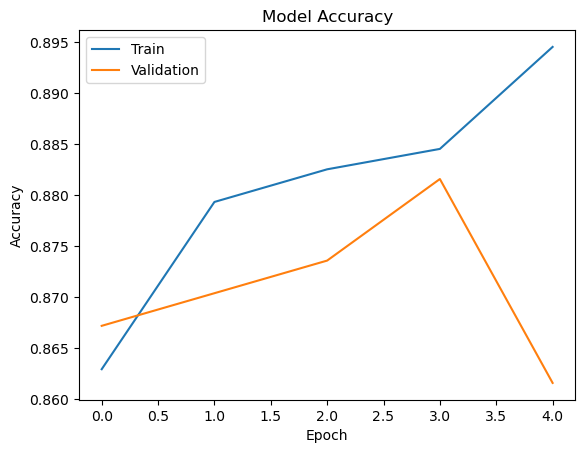

In [176]:
# Train the model but I want to display the training accuracy and loss and the validation accuracy and loss in a graph
history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=5, batch_size=32, verbose=1)

# Plot the training and validation accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [177]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_tensor, y_test_tensor)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


40/40 [==============================] - 1s 21ms/step - loss: 0.3660 - binary_accuracy: 0.8616
Test Loss: 0.3659834861755371
Test Accuracy: 0.8615999817848206


In [178]:
# macro F1 score and confusion matrix
from sklearn.metrics import f1_score, confusion_matrix

# Predict the test set
y_pred = model.predict(X_test_tensor)

# Convert the predictions to binary
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate the macro F1 score
f1 = f1_score(y_test, y_pred_binary, average='macro')

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Display the results
print(f'Macro F1 Score: {f1}')
print(f'Confusion Matrix:\n{cm}')


40/40 [==============================] - 1s 21ms/step
Macro F1 Score: 0.8170181188024144
Confusion Matrix:
[[847  61]
 [112 230]]


In [179]:
# weighted f1 score
from sklearn.metrics import f1_score

# Calculate the weighted F1 score
f1_weighted = f1_score(y_test, y_pred_binary, average='weighted')

# Display the weighted F1 score
print(f'Weighted F1 Score: {f1_weighted}')

#classification report
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred_binary)

# Display the classification report
print(report)


Weighted F1 Score: 0.8579149498523875
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       908
           1       0.79      0.67      0.73       342

    accuracy                           0.86      1250
   macro avg       0.84      0.80      0.82      1250
weighted avg       0.86      0.86      0.86      1250



In [180]:
#lets build a rf now 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict the test set
y_pred_rf = rf.predict(X_test)

# Calculate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Display the accuracy
print(f'Random Forest Accuracy: {accuracy_rf}')

# Calculate the macro F1 score
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

# Display the macro F1 score
print(f'Random Forest Macro F1 Score: {f1_rf}')

# Calculate the weighted F1 score
f1_weighted_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Display the weighted F1 score
print(f'Random Forest Weighted F1 Score: {f1_weighted_rf}')

# Generate the classification report
report_rf = classification_report(y_test, y_pred_rf)

# Display the classification report
print(report_rf)


Random Forest Accuracy: 0.8904
Random Forest Macro F1 Score: 0.8644413678241989
Random Forest Weighted F1 Score: 0.8913016709530901
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       908
           1       0.78      0.83      0.81       342

    accuracy                           0.89      1250
   macro avg       0.86      0.87      0.86      1250
weighted avg       0.89      0.89      0.89      1250

